In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
import deepdish as dd
from itertools import compress

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
hw_cw_data = dd.io.load('2018_2_14_hws_cws_data.h5')
contour_data = dd.io.load('2018_2_14_contour_plot_data.h5')

In [3]:
hw_cw_data.keys()

dict_keys(['cws', 'hws', 'infos'])

In [4]:
contour_data.keys()

dict_keys(['data_multicell_info', 'data_singlecell_info', 'multi_cell_info', 'single_cell_info'])

In [5]:
data_multicell_info = contour_data['data_multicell_info']
data_singlecell_info = contour_data['data_singlecell_info']
multi_cell_info = contour_data['multi_cell_info']
single_cell_info = contour_data['single_cell_info']

In [6]:
def unravel_polyfit(p, x):
    unraveled = []
    degs = np.arange(len(p))[::-1]
    for xi in x:
        term = 0.0
        for pi, deg in zip(p, degs):
            term += pi * xi**deg
        unraveled.append(term)
    return unraveled

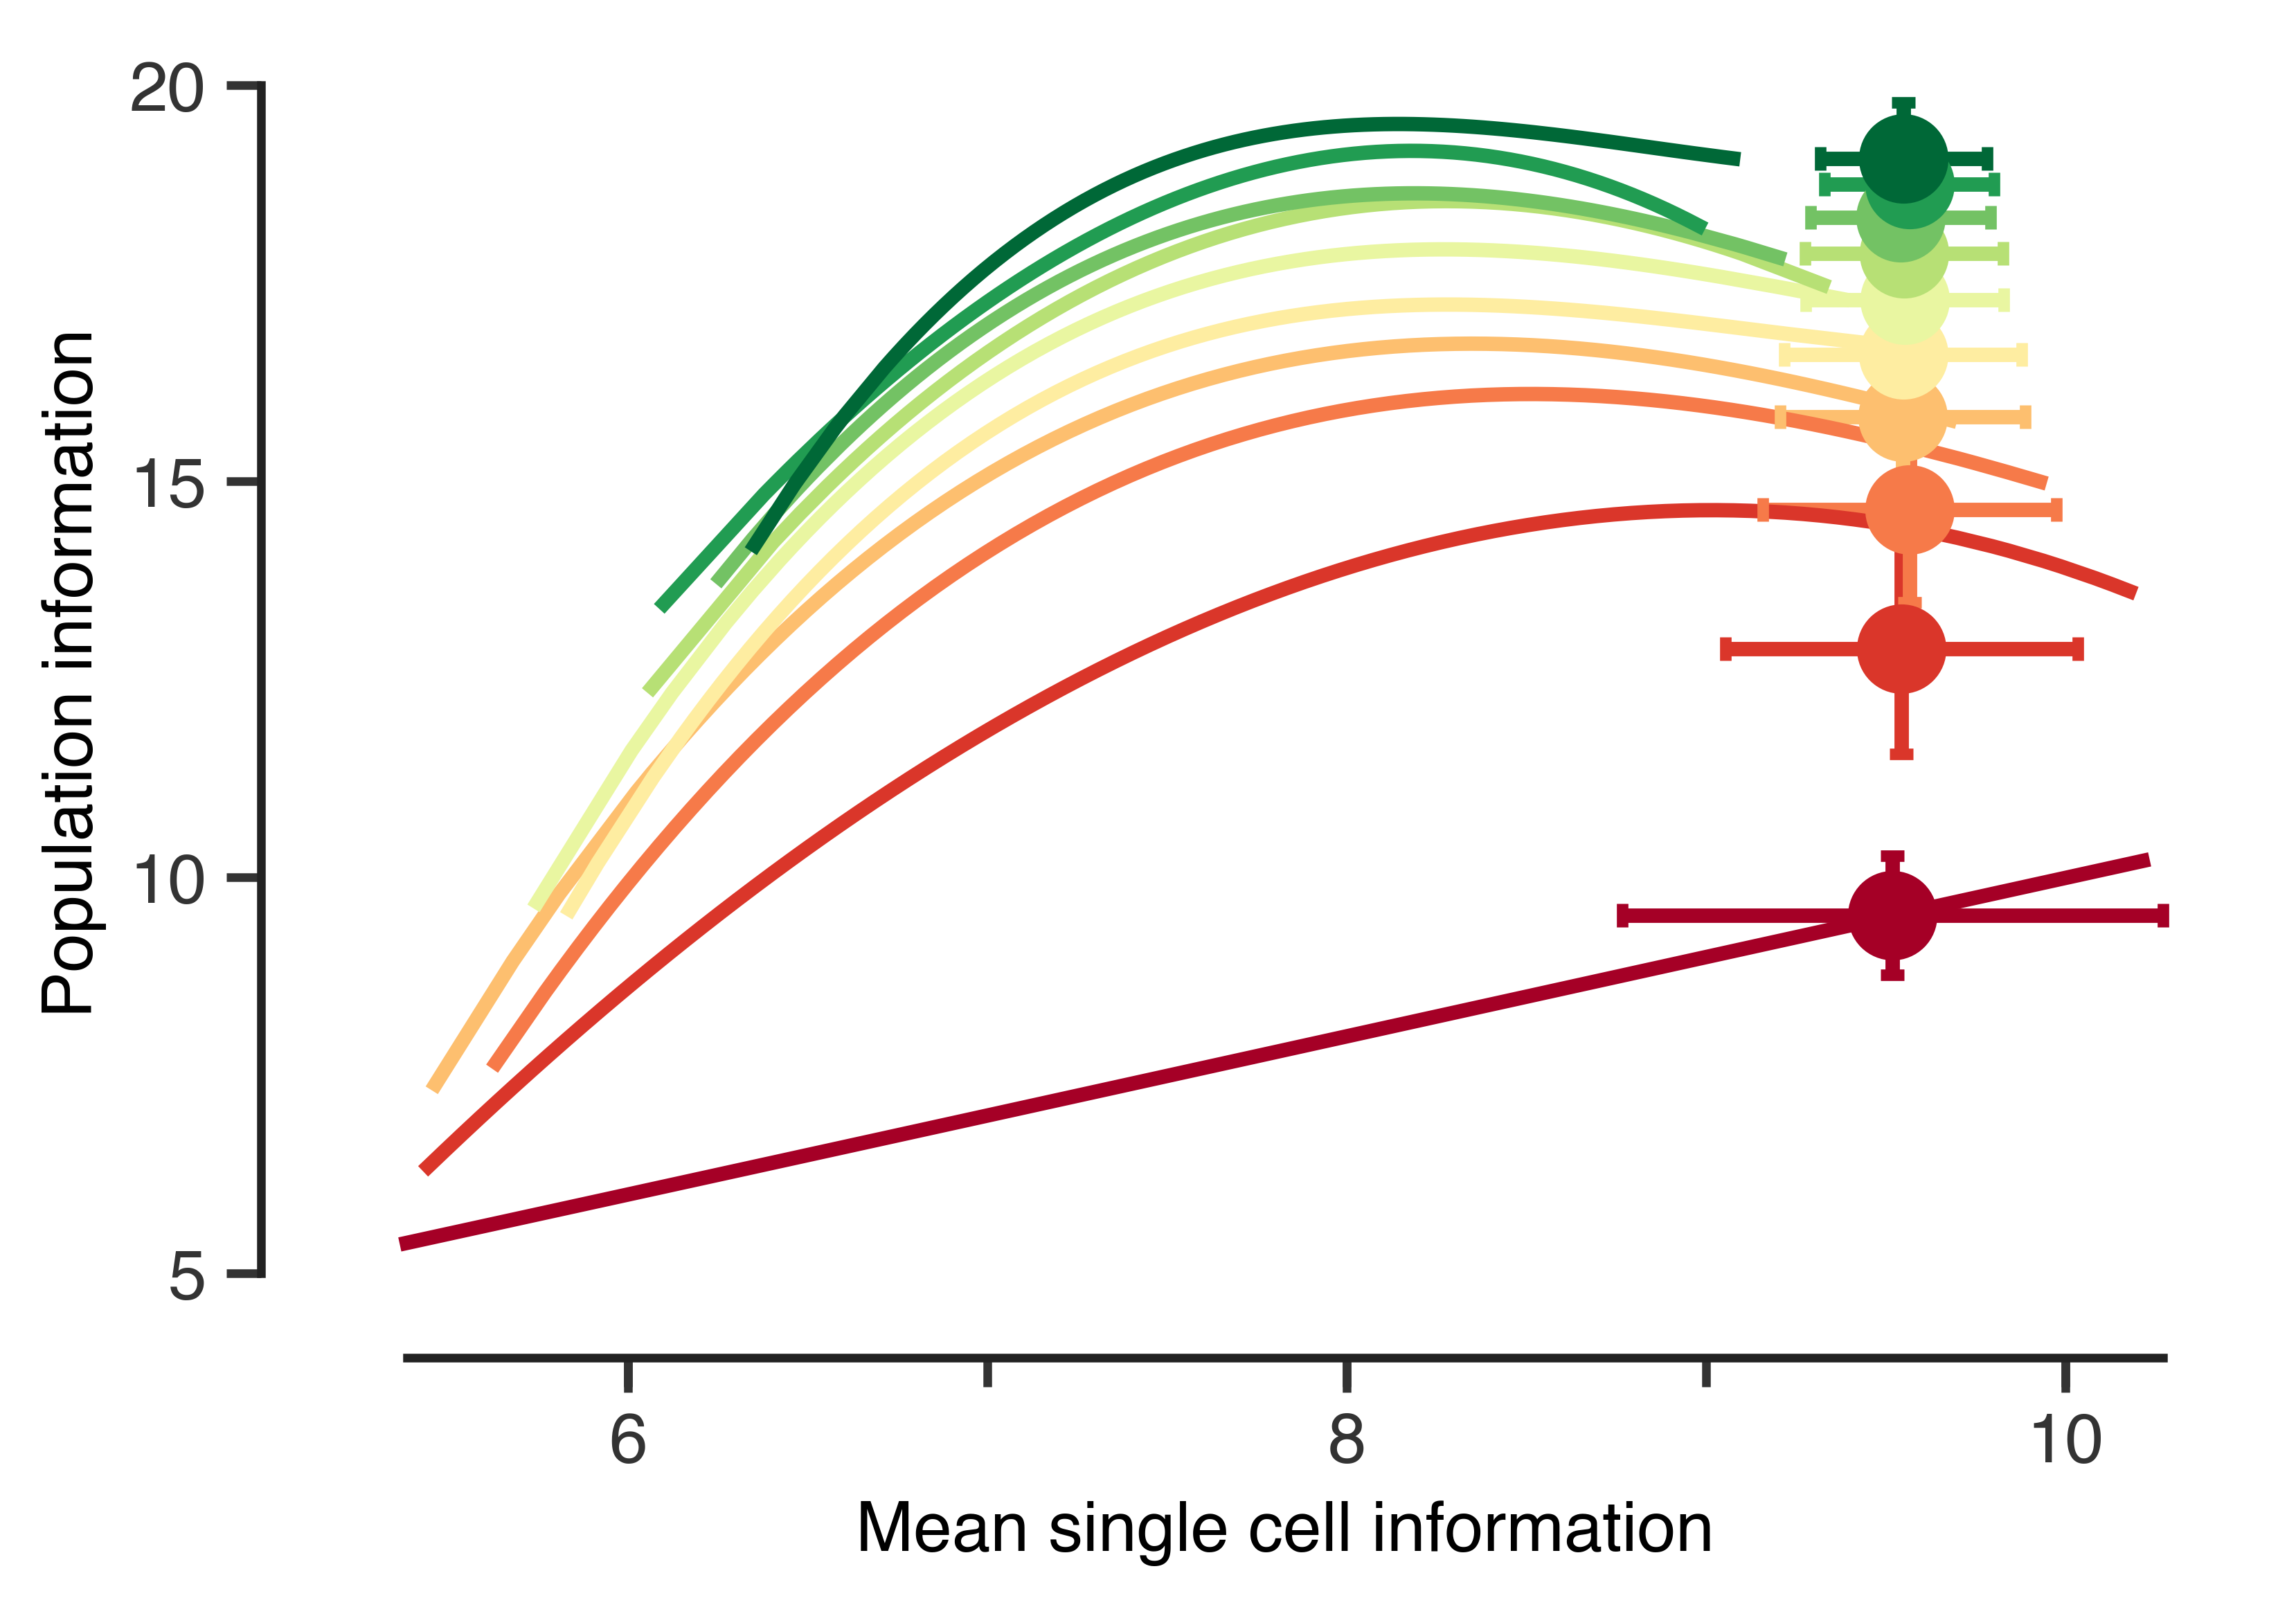

In [7]:
colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 10))

bin_size = [100]
deg = 3
for i in range(1, 11):
    for s in bin_size:
        single_bins = np.linspace(np.min(single_cell_info[i]), np.max(single_cell_info[i]), s + 1)
        if i == 1:
            range_of_bins = single_bins
        max_multi_info = []
        for k, b in enumerate(single_bins[:-1]):
            relevant_indices = (b <= single_cell_info[i]) * (single_bins[k + 1] > single_cell_info[i])
            relevant_single_info = list(compress(single_cell_info[i], relevant_indices))
            if relevant_single_info:
                max_multi_info.append(max(list(compress(multi_cell_info[i], relevant_indices))))
            else:
                max_multi_info.append(None)
                
        remaining_idxs = [idx for idx in range(len(max_multi_info)) if max_multi_info[idx]]
        remaining_maxs = np.array(max_multi_info)[remaining_idxs]
        remaining_bins = single_bins[1:][remaining_idxs]
        p = np.polyfit(remaining_bins, remaining_maxs, deg)
        plt.plot(remaining_bins, unravel_polyfit(p, remaining_bins), label=f'filters={i}, bins={s}',
                 color=colors[i-1])
#         plt.plot(range_of_bins, unravel_polyfit(p, range_of_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])
        
        plt.errorbar(np.mean(data_singlecell_info[i]), np.mean(data_multicell_info[i]),
                     yerr=np.std(data_multicell_info[i]), xerr=np.std(data_singlecell_info[i]),
                     fmt='o', ecolor=colors[i-1], color=colors[i-1], capthick=2, capsize=2)
#     plt.legend(frameon=False, loc='lower right')

majorLocator = MultipleLocator(5)
majorLocatorx = MultipleLocator(2)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(1)

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_major_locator(majorLocatorx)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)

adjust_spines(plt.gca())
plt.xlabel('Mean single cell information')
plt.ylabel('Population information')

In [8]:
info_comparison = dd.io.load('2018_2_14_info_comparison.h5')

In [9]:
info_comparison.keys()

dict_keys(['global_opt', 'mean_data_info_vs_filters', 'sem_data_info_vs_filters', 'single_cell_opt', 'varied_cw_fixed_hw', 'varied_hw_fixed_cw'])

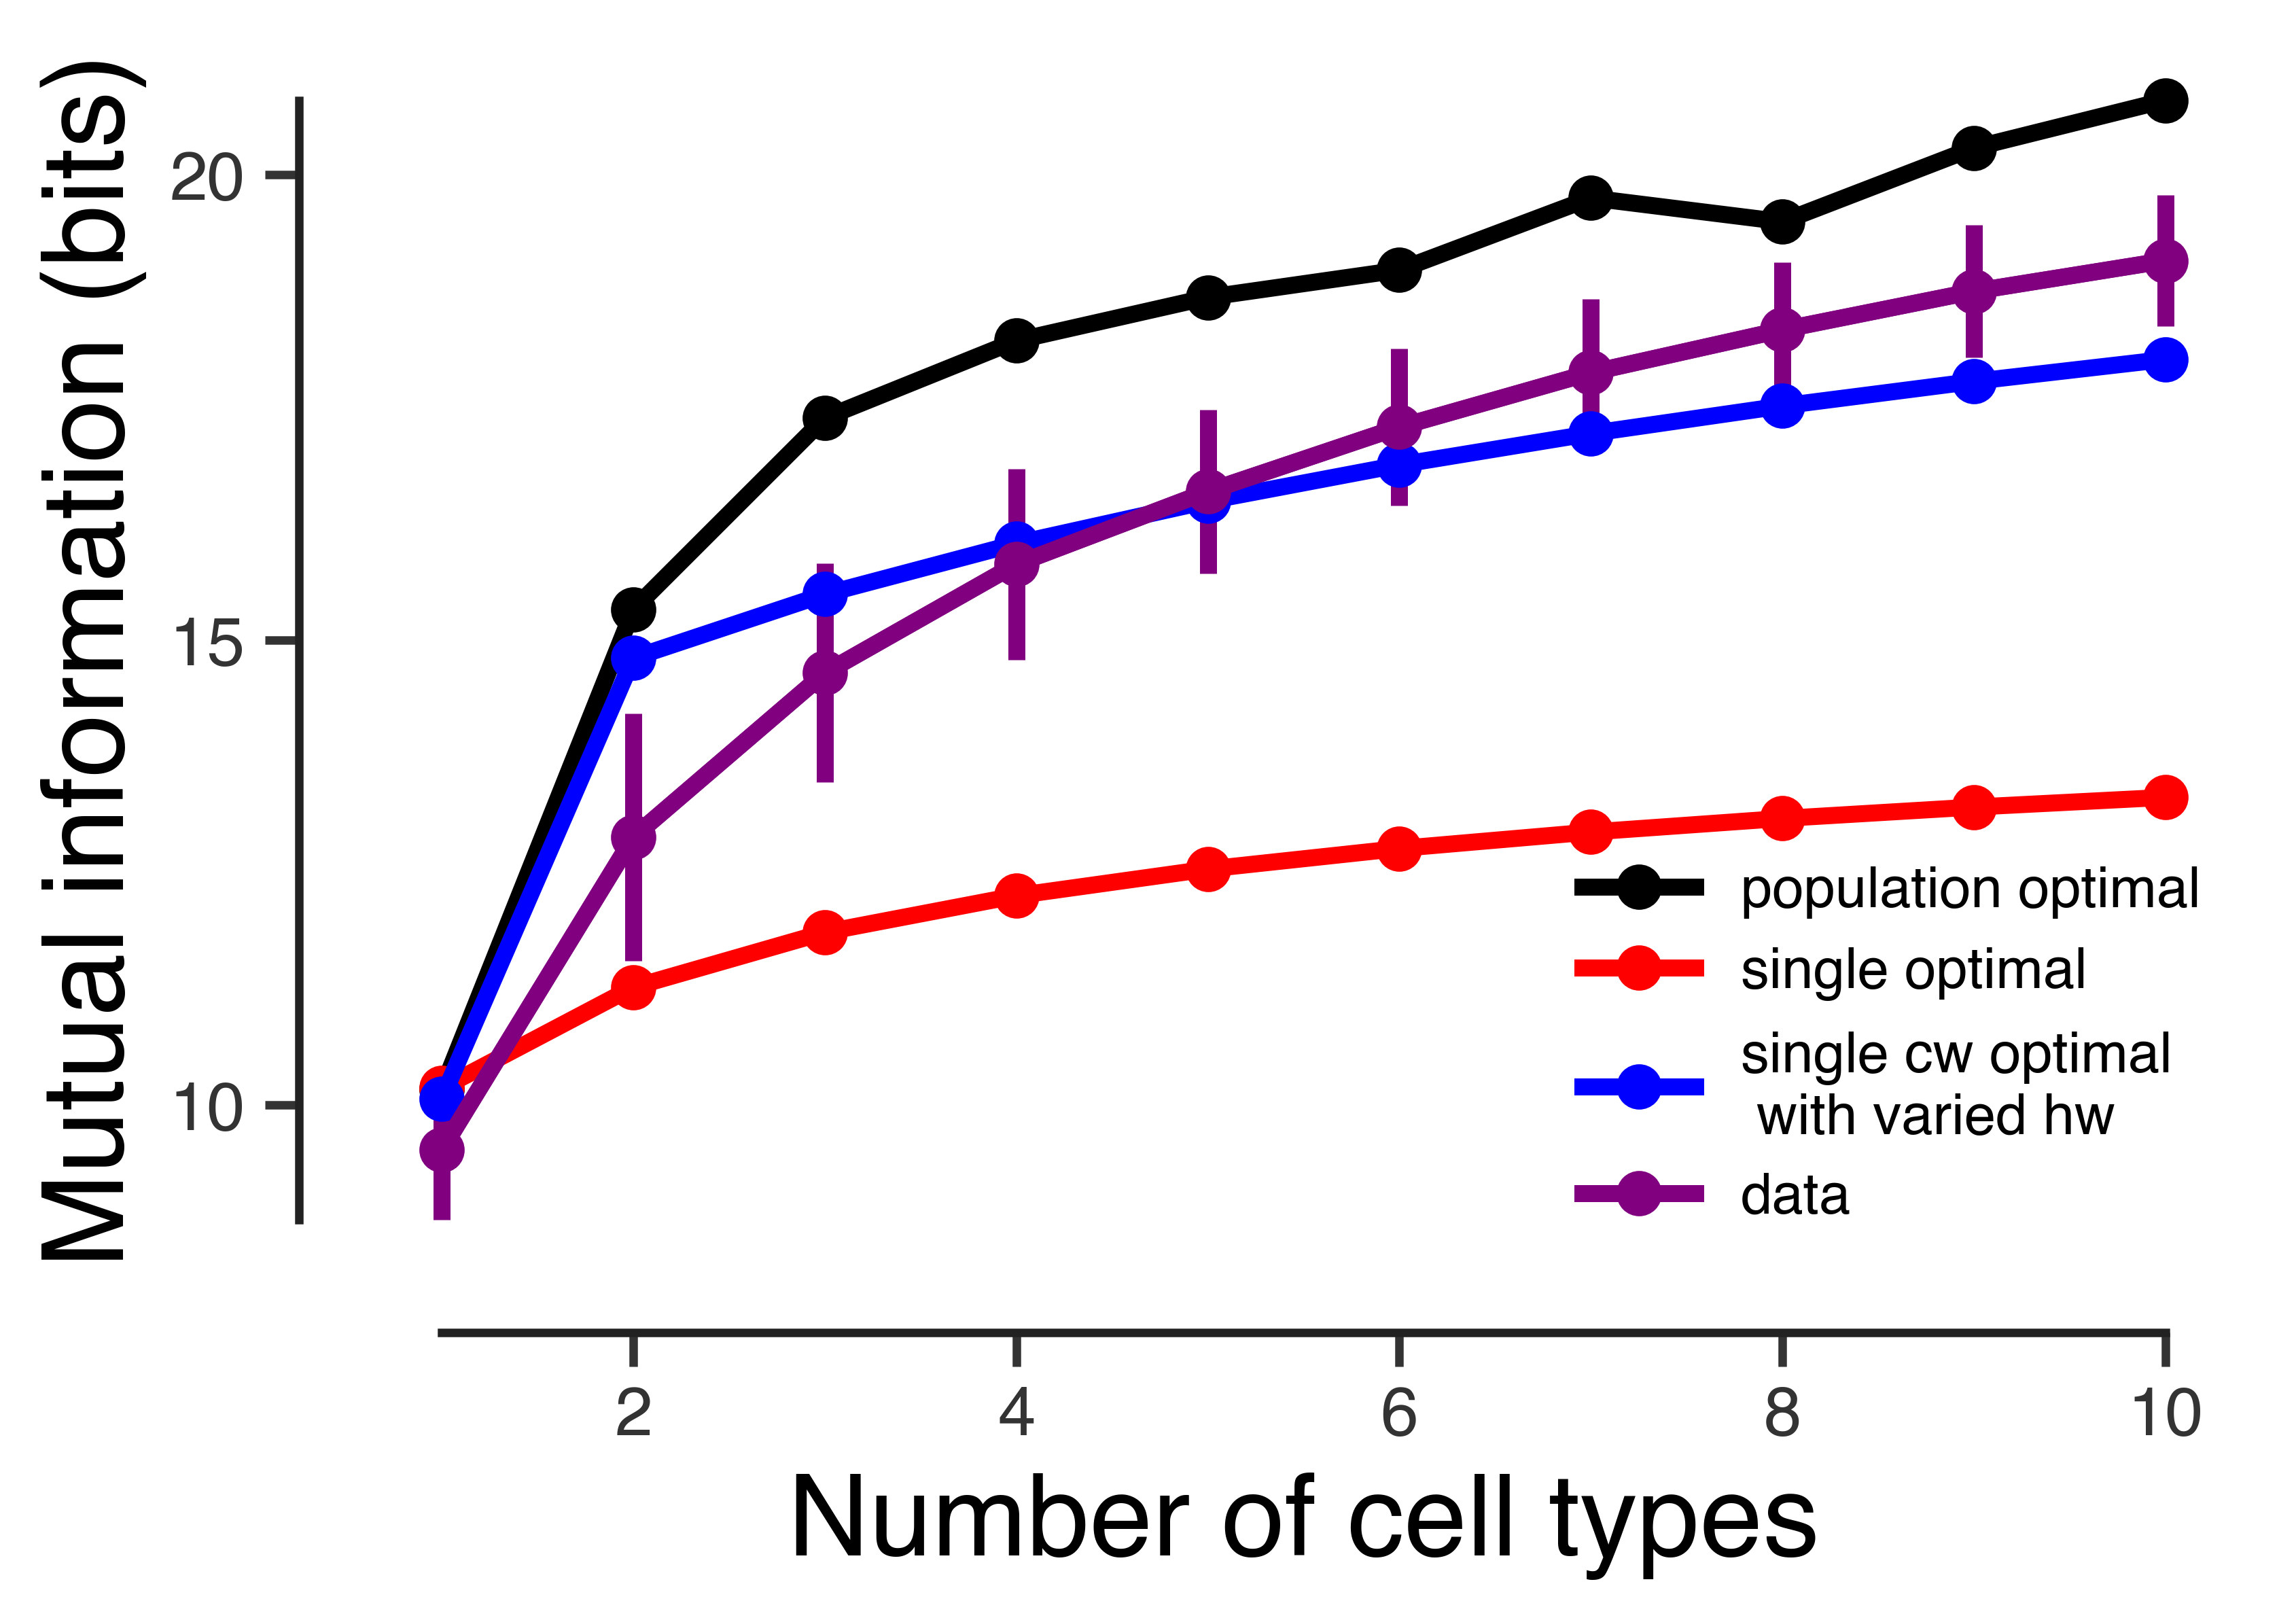

In [87]:
plt.plot(np.arange(1,11), info_comparison['global_opt'], 'k', linewidth=3, marker='.', 
         markersize=15, label='population optimal')
plt.plot(np.arange(1,11), info_comparison['single_cell_opt'], 'r', linewidth=3, marker='.', 
         markersize=15, label='single optimal')
plt.plot(np.arange(1,11), info_comparison['varied_hw_fixed_cw'], 'b', linewidth=3, marker='.', 
         markersize=15, label='single cw optimal \n with varied hw')
# plt.plot(np.arange(1,11), splitting_cws_fun, 'c', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), info_comparison['mean_data_info_vs_filters'], linewidth=3,
         color='purple', marker='.', markersize=15, label='data')
plt.errorbar(np.arange(1,11), info_comparison['mean_data_info_vs_filters'], 
             yerr=[np.std(data_multicell_info[i]) for i in range(1, 11)], linewidth=3, color='purple')
plt.xlabel('Number of cell types', fontsize=20)
plt.ylabel('Mutual information (bits)', fontsize=20)
plt.legend(loc='lower right', frameon=False, fontsize=10)
# plt.ylim(5, 22)

majorLocator = MultipleLocator(5)
majorLocatorx = MultipleLocator(2)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(1)

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.xaxis.set_major_locator(majorLocatorx)
# ax.xaxis.set_major_formatter(majorFormatter)
# ax.xaxis.set_minor_locator(minorLocator)

adjust_spines(plt.gca())

In [11]:
sorted_solns = np.argsort(hw_cw_data['infos'])[::-1]

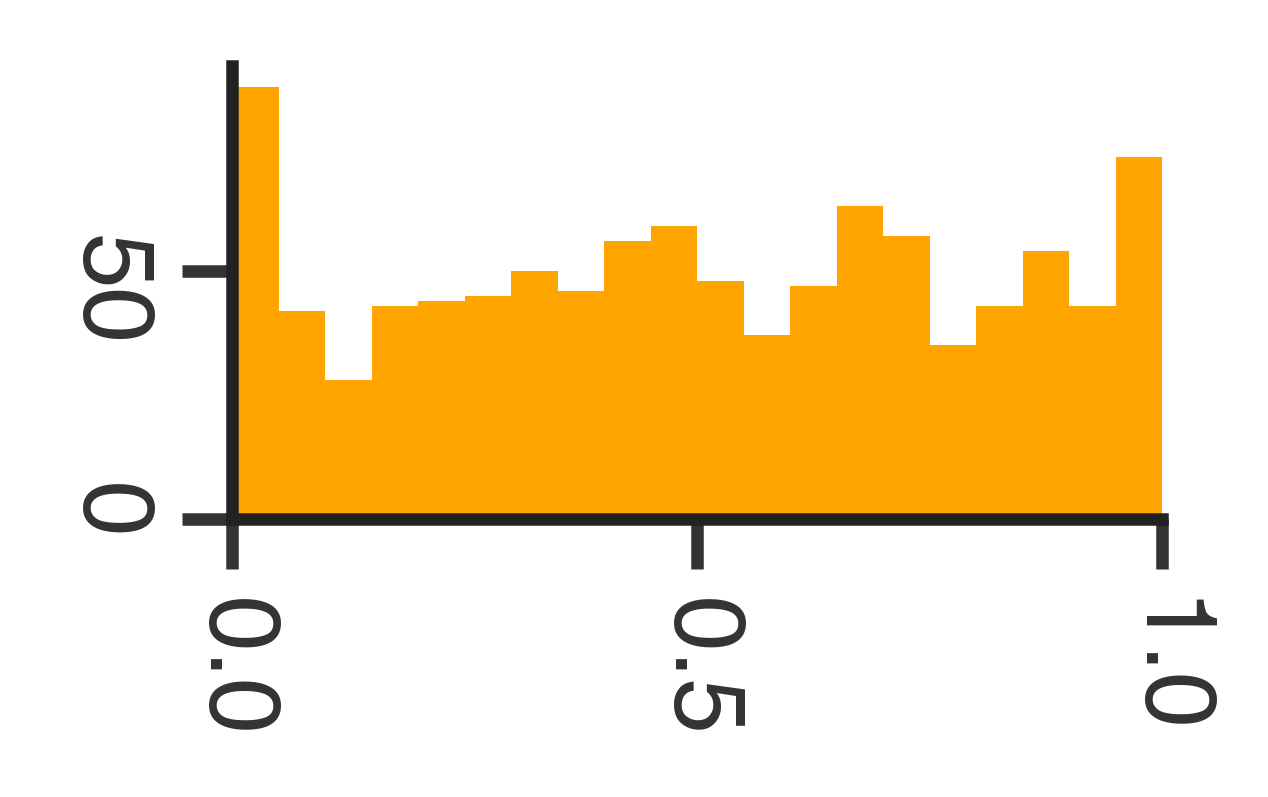

In [88]:
fig = plt.figure(figsize=(2, 1))
count, bins = np.histogram(np.array(hw_cw_data['hws'])[sorted_solns[:200]], bins=20)
bin_width = np.mean(np.diff(bins))
plt.bar(bins[:-1] + bin_width/2.0, count, width=bin_width, color='orange')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlim(0, 1)
plt.yticks([0, 50], rotation=270)
plt.xticks([0.0, 0.5, 1.0], rotation=270)
plt.savefig('2018_2_17_hw_distribution.png')

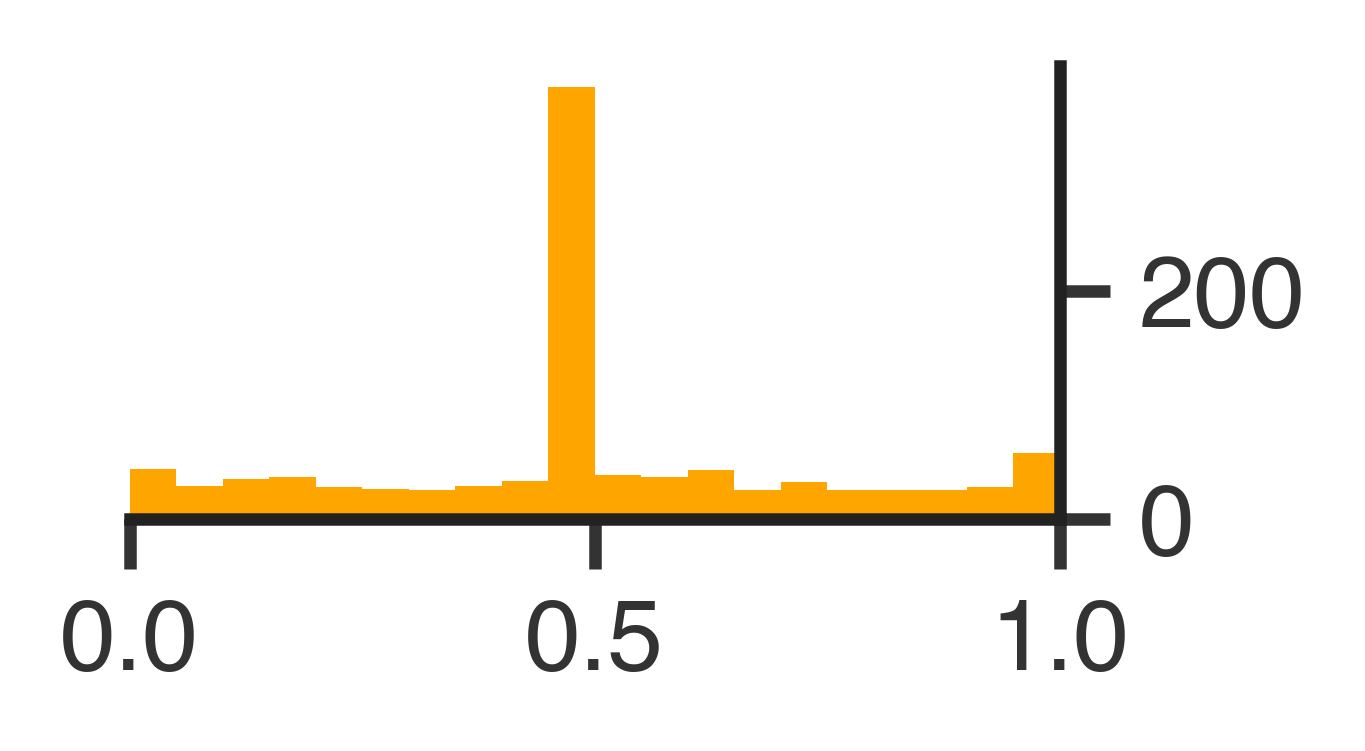

In [89]:
fig = plt.figure(figsize=(2, 1))
count, bins = np.histogram(np.array(hw_cw_data['cws'])[sorted_solns[:200]], bins=20)
bin_width = np.mean(np.diff(bins))
plt.bar(bins[:-1] + bin_width/2.0, count, width=bin_width, color='orange')
ax = plt.gca()
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.xaxis.set_ticks_position('bottom')
plt.xlim(0, 1)
plt.savefig('2018_2_17_cw_distribution.png')

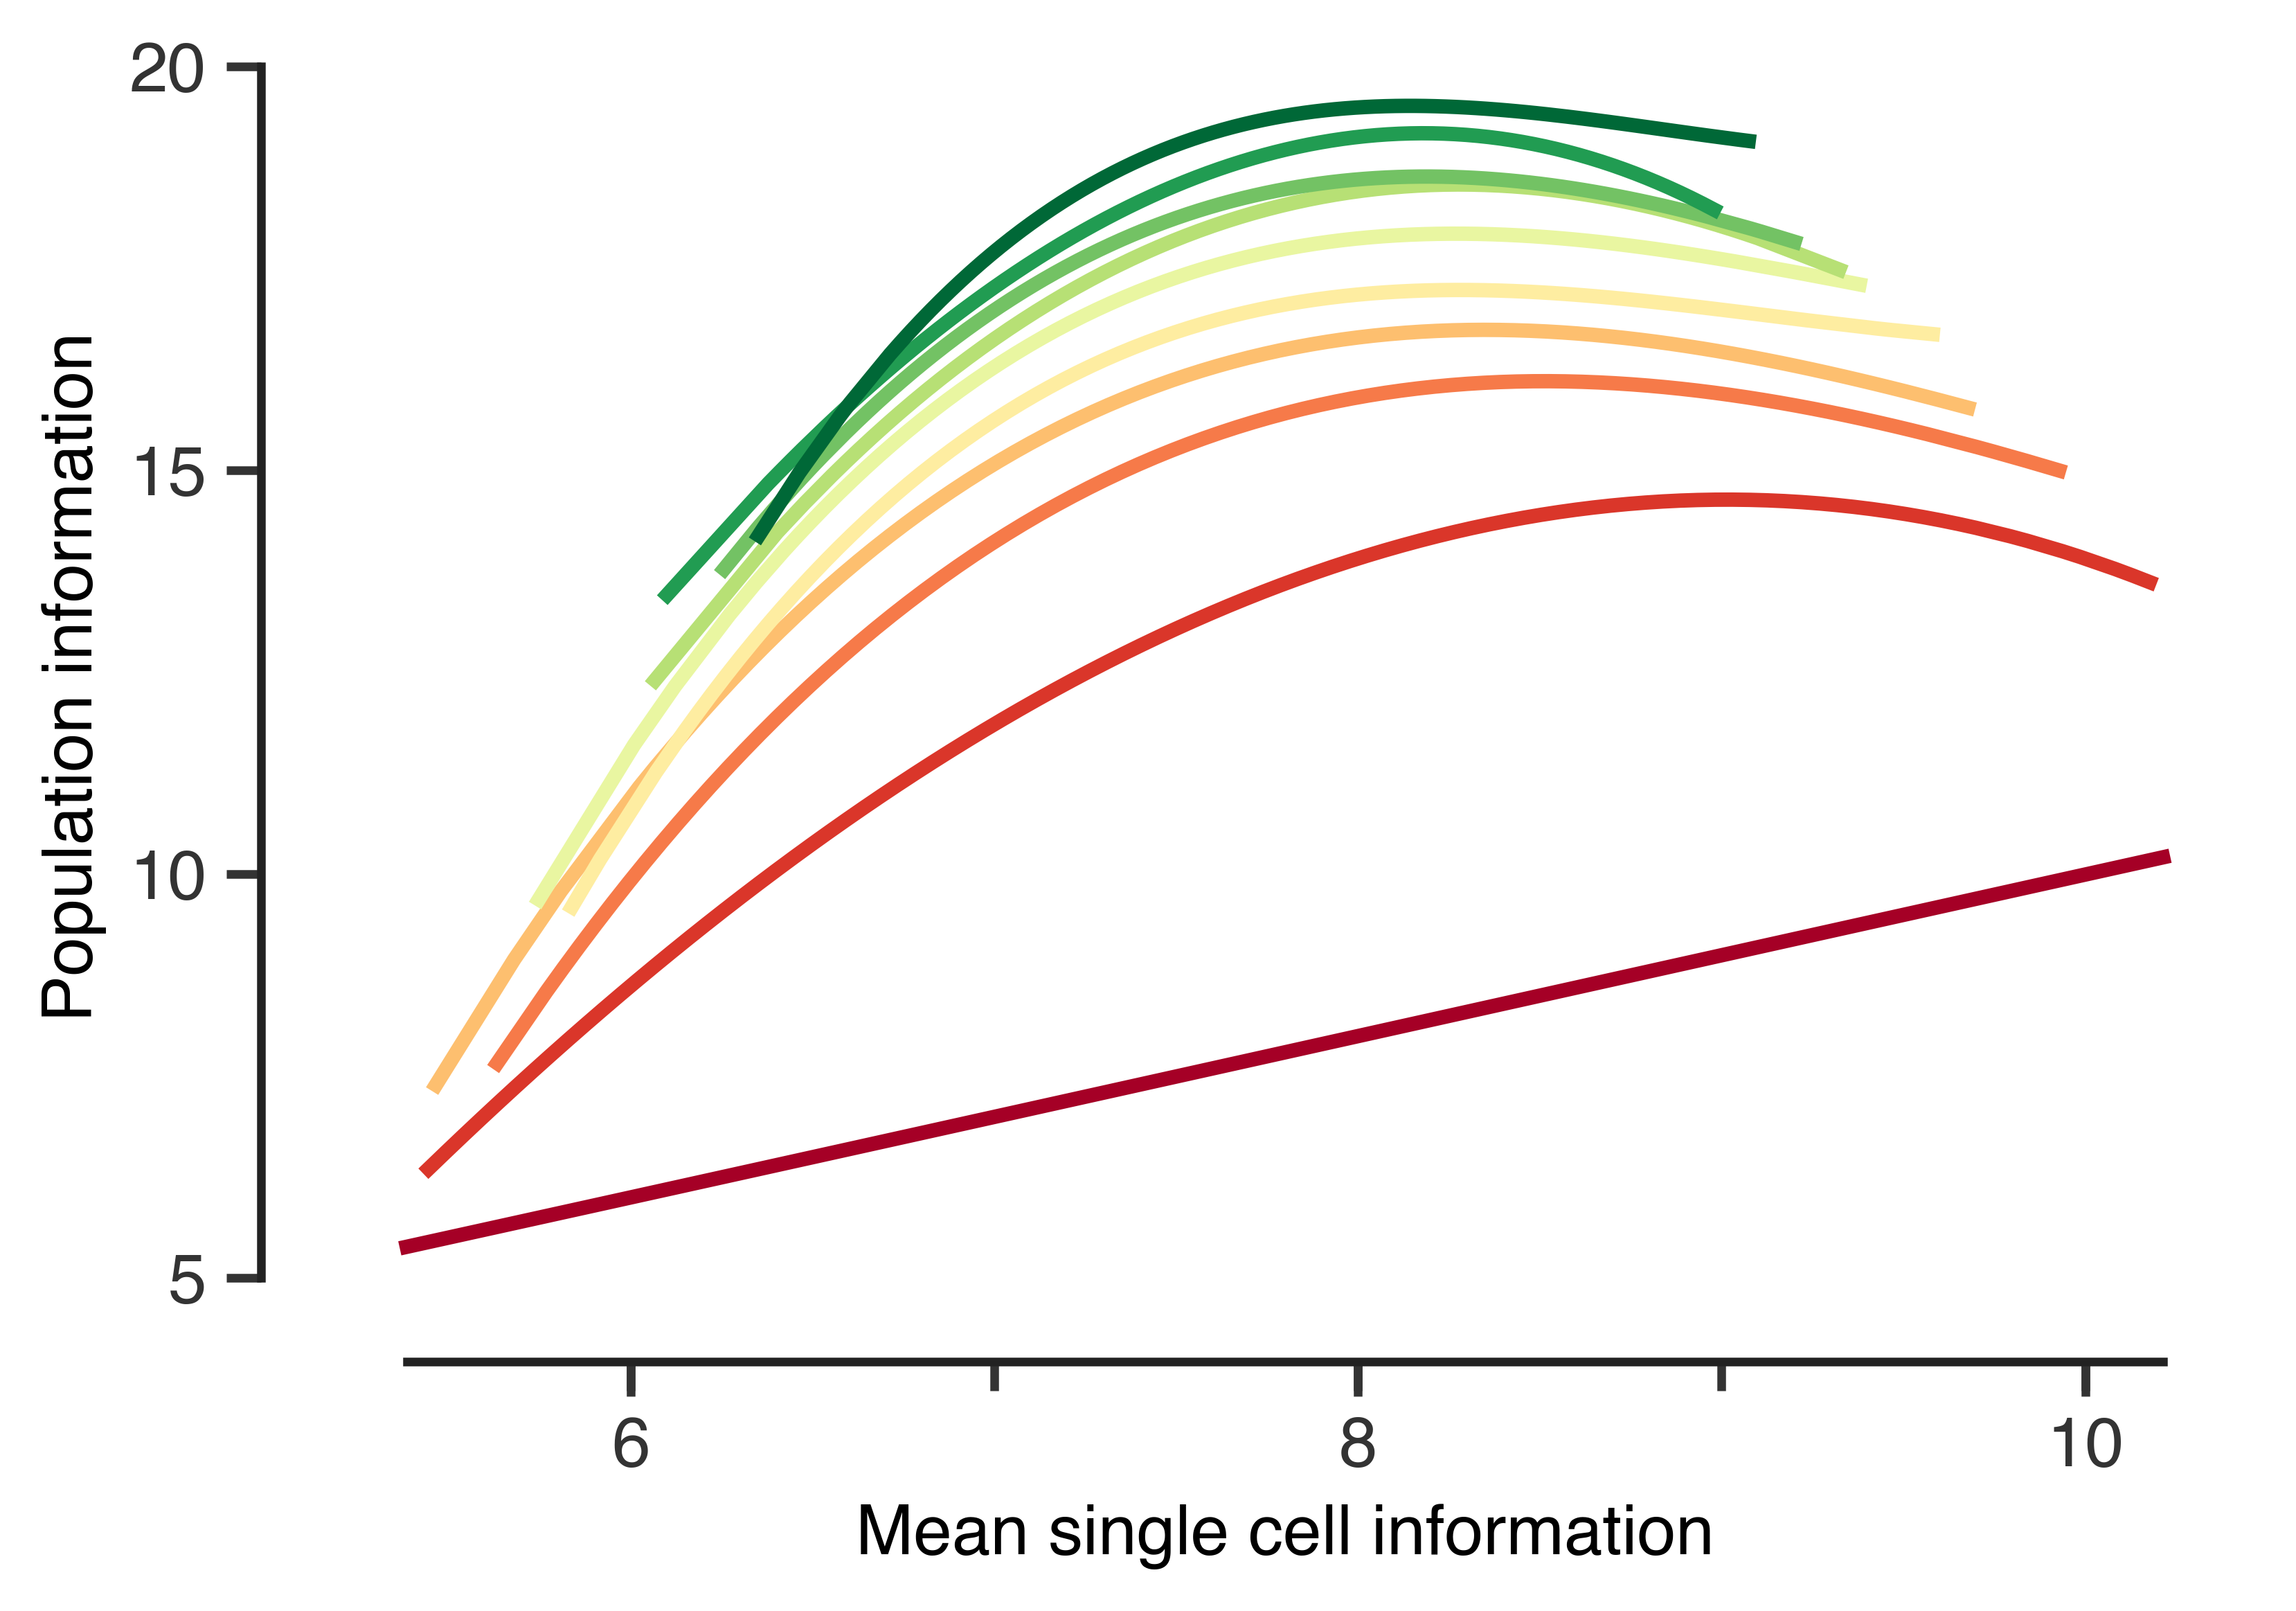

In [14]:
colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 10))

bin_size = [100]
deg = 3
for i in range(1, 11):
    for s in bin_size:
        single_bins = np.linspace(np.min(single_cell_info[i]), np.max(single_cell_info[i]), s + 1)
        if i == 1:
            range_of_bins = single_bins
        max_multi_info = []
        for k, b in enumerate(single_bins[:-1]):
            relevant_indices = (b <= single_cell_info[i]) * (single_bins[k + 1] > single_cell_info[i])
            relevant_single_info = list(compress(single_cell_info[i], relevant_indices))
            if relevant_single_info:
                max_multi_info.append(max(list(compress(multi_cell_info[i], relevant_indices))))
            else:
                max_multi_info.append(None)
                
        remaining_idxs = [idx for idx in range(len(max_multi_info)) if max_multi_info[idx]]
        remaining_maxs = np.array(max_multi_info)[remaining_idxs]
        remaining_bins = single_bins[1:][remaining_idxs]
        p = np.polyfit(remaining_bins, remaining_maxs, deg)
        plt.plot(remaining_bins, unravel_polyfit(p, remaining_bins), label=f'filters={i}, bins={s}',
                 color=colors[i-1])
#         plt.plot(range_of_bins, unravel_polyfit(p, range_of_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])
        
#         plt.errorbar(np.mean(data_singlecell_info[i]), np.mean(data_multicell_info[i]),
#                      yerr=np.std(data_multicell_info[i]), xerr=np.std(data_singlecell_info[i]),
#                      fmt='o', ecolor=colors[i-1], color=colors[i-1], capthick=2, capsize=2)
#     plt.legend(frameon=False, loc='lower right')

majorLocator = MultipleLocator(5)
majorLocatorx = MultipleLocator(2)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(1)

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_major_locator(majorLocatorx)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)

adjust_spines(plt.gca())
plt.xlabel('Mean single cell information')
plt.ylabel('Population information')

In [15]:
single_optimal_dict = dd.io.load('2018_2_14_sorted_optimal_cws_hws_data.h5')

In [16]:
single_optimal_dict.keys()

dict_keys(['sorted_optimal_cws', 'sorted_optimal_hws'])

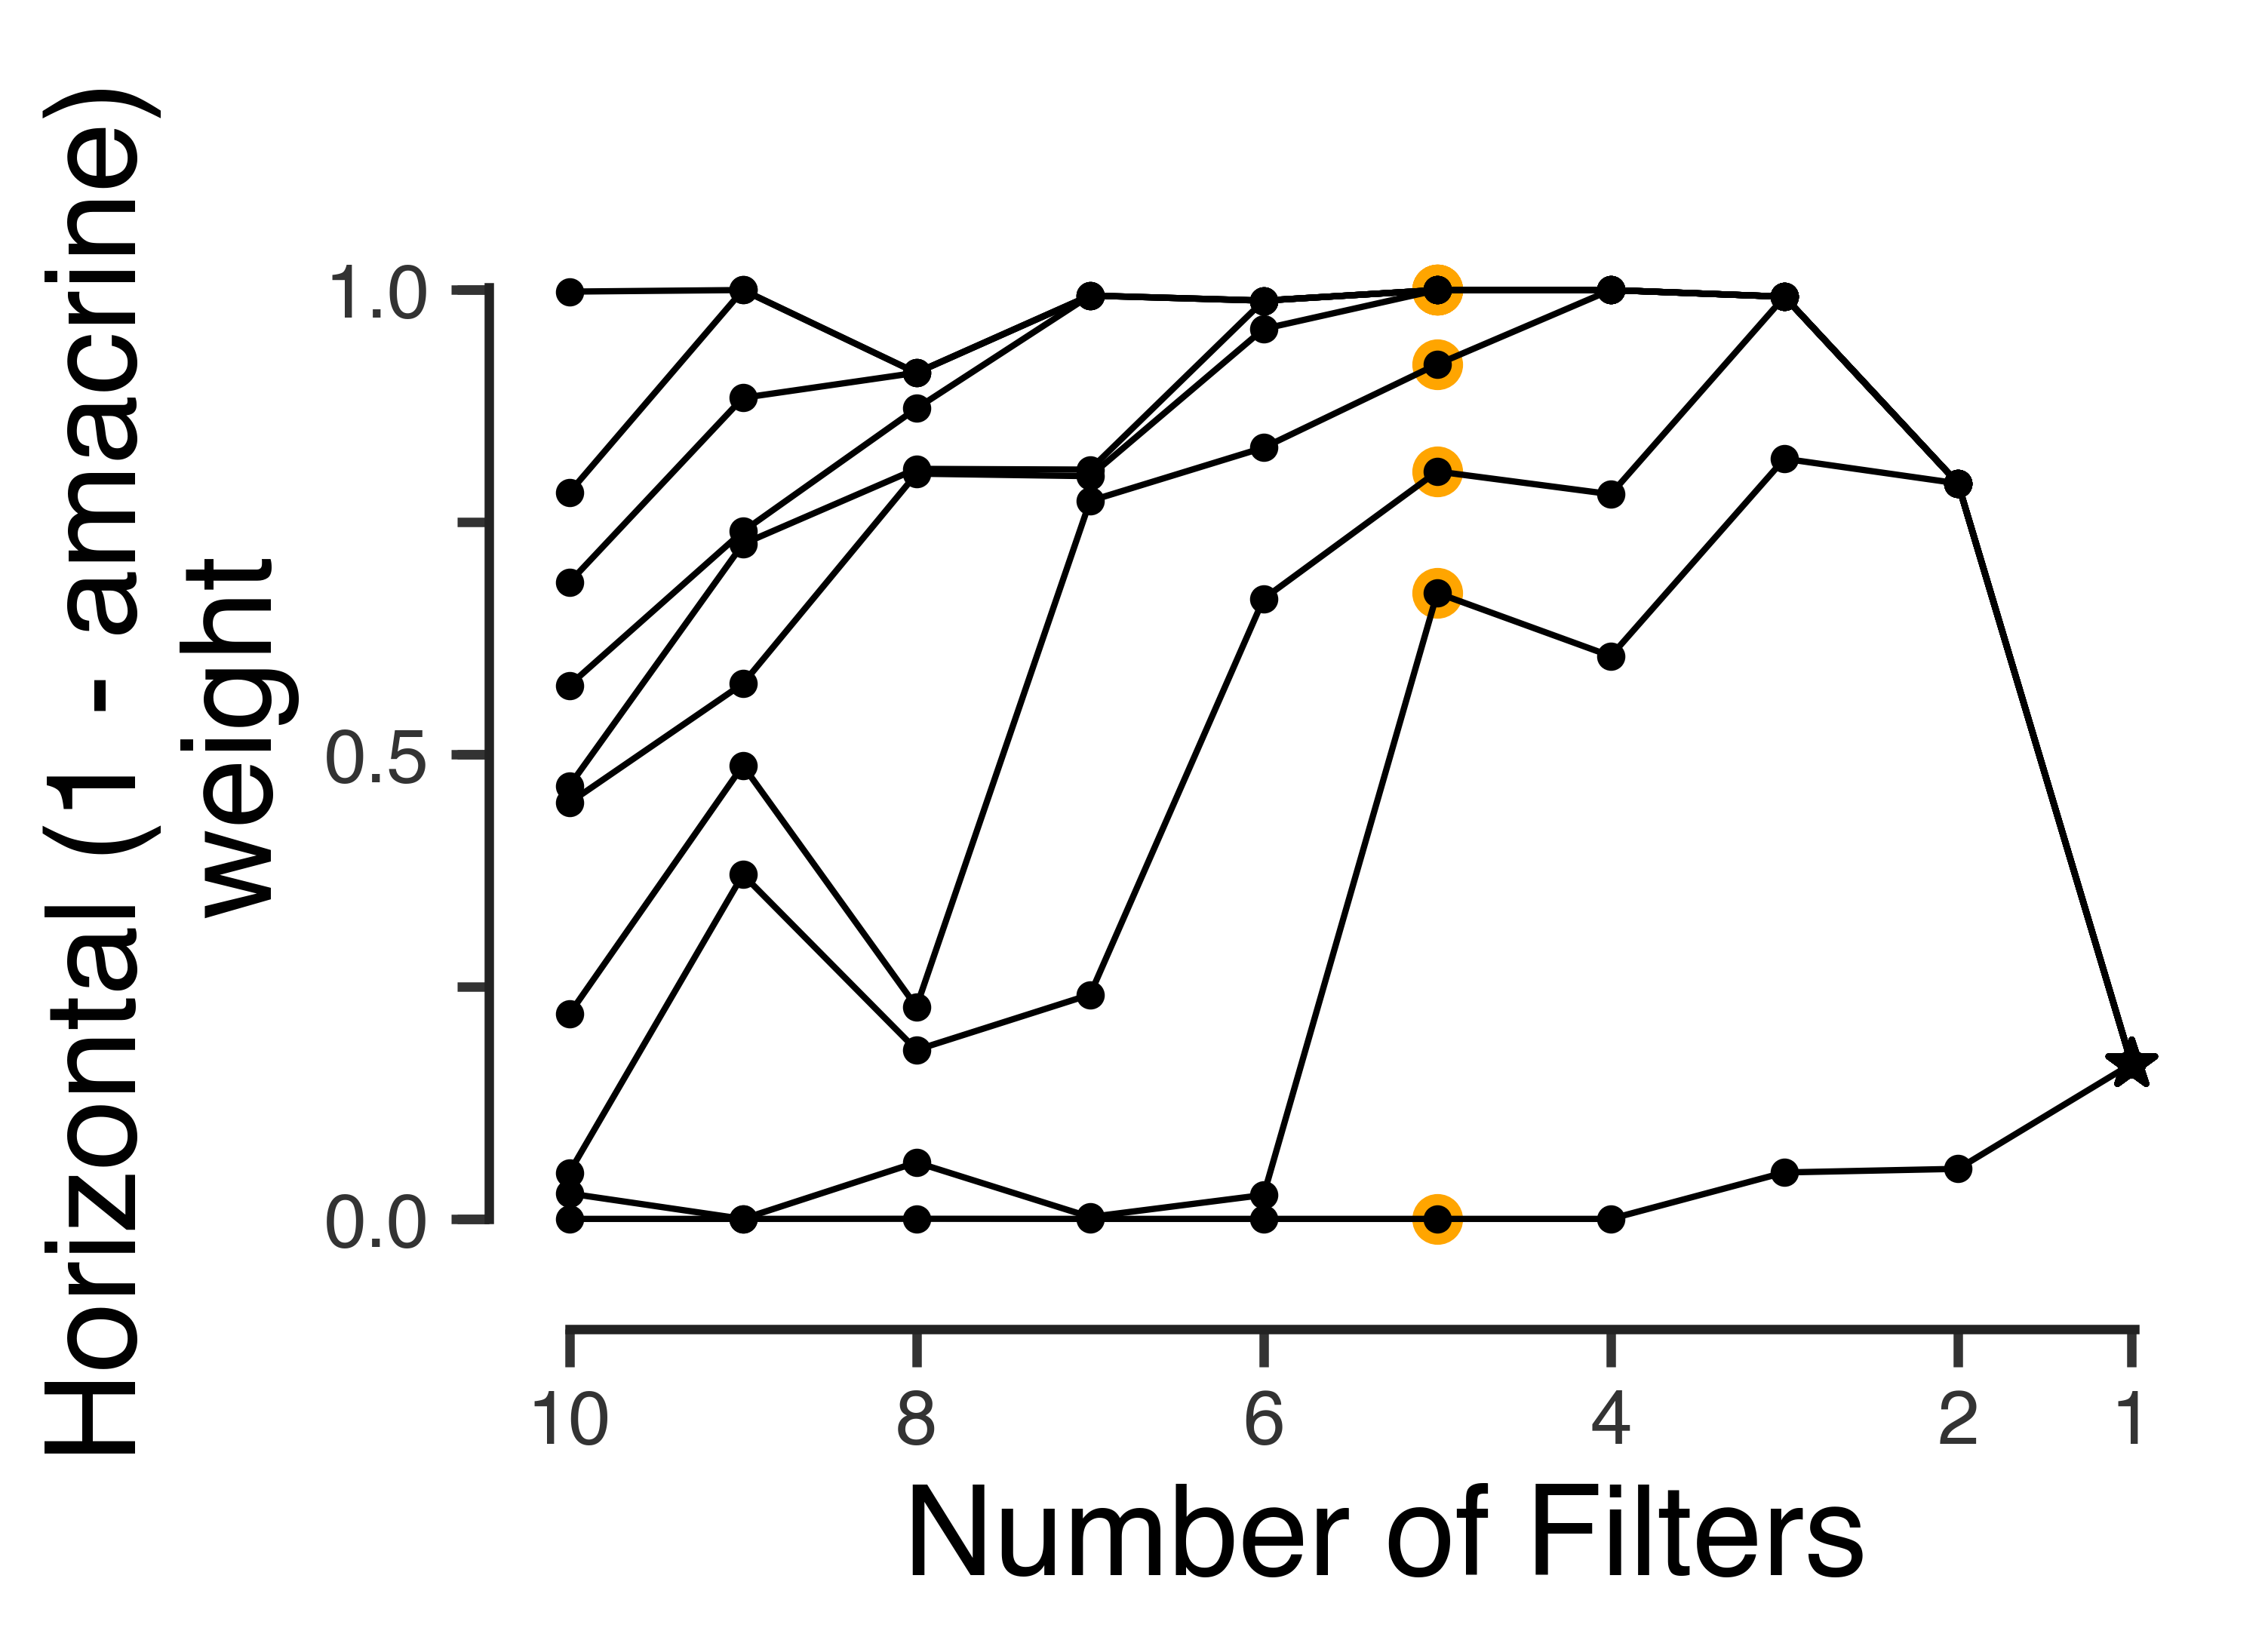

In [132]:
fig = plt.figure(figsize=(4.75, 3))
for depth in range(len(single_optimal_dict['sorted_optimal_hws'][-1])):
    this_series = []
    for num_filt in range(len(single_optimal_dict['sorted_optimal_hws'])):
        index = np.min([len(single_optimal_dict['sorted_optimal_hws'][num_filt]) - 1, depth])
        this_series.append(single_optimal_dict['sorted_optimal_hws'][num_filt][index])
    plt.plot(np.arange(1, 11), this_series, 'k', marker='.', markersize=8, linewidth=1)
    plt.scatter(1, this_series[0], marker='*', color='k', s=60)
    plt.scatter(5, this_series[4], color='orange', s=50)
plt.ylabel('Horizontal (1 - amacrine) \n weight', fontsize=20)
plt.xlabel('Number of Filters', fontsize=20)
plt.xlim(10.1, 0.5)

majorLocator = MultipleLocator(0.5)
majorLocatorx = MultipleLocator(2)
majorFormatter = FormatStrFormatter('%0.1f')
majorFormatterx = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_major_locator(majorLocatorx)
ax.xaxis.set_major_formatter(majorFormatterx)
ax.yaxis.set_minor_locator(minorLocator)

plt.xticks([1, 2, 4, 6, 8, 10])


adjust_spines(plt.gca())
plt.savefig('2018_2_17_hws_vs_filters.png')

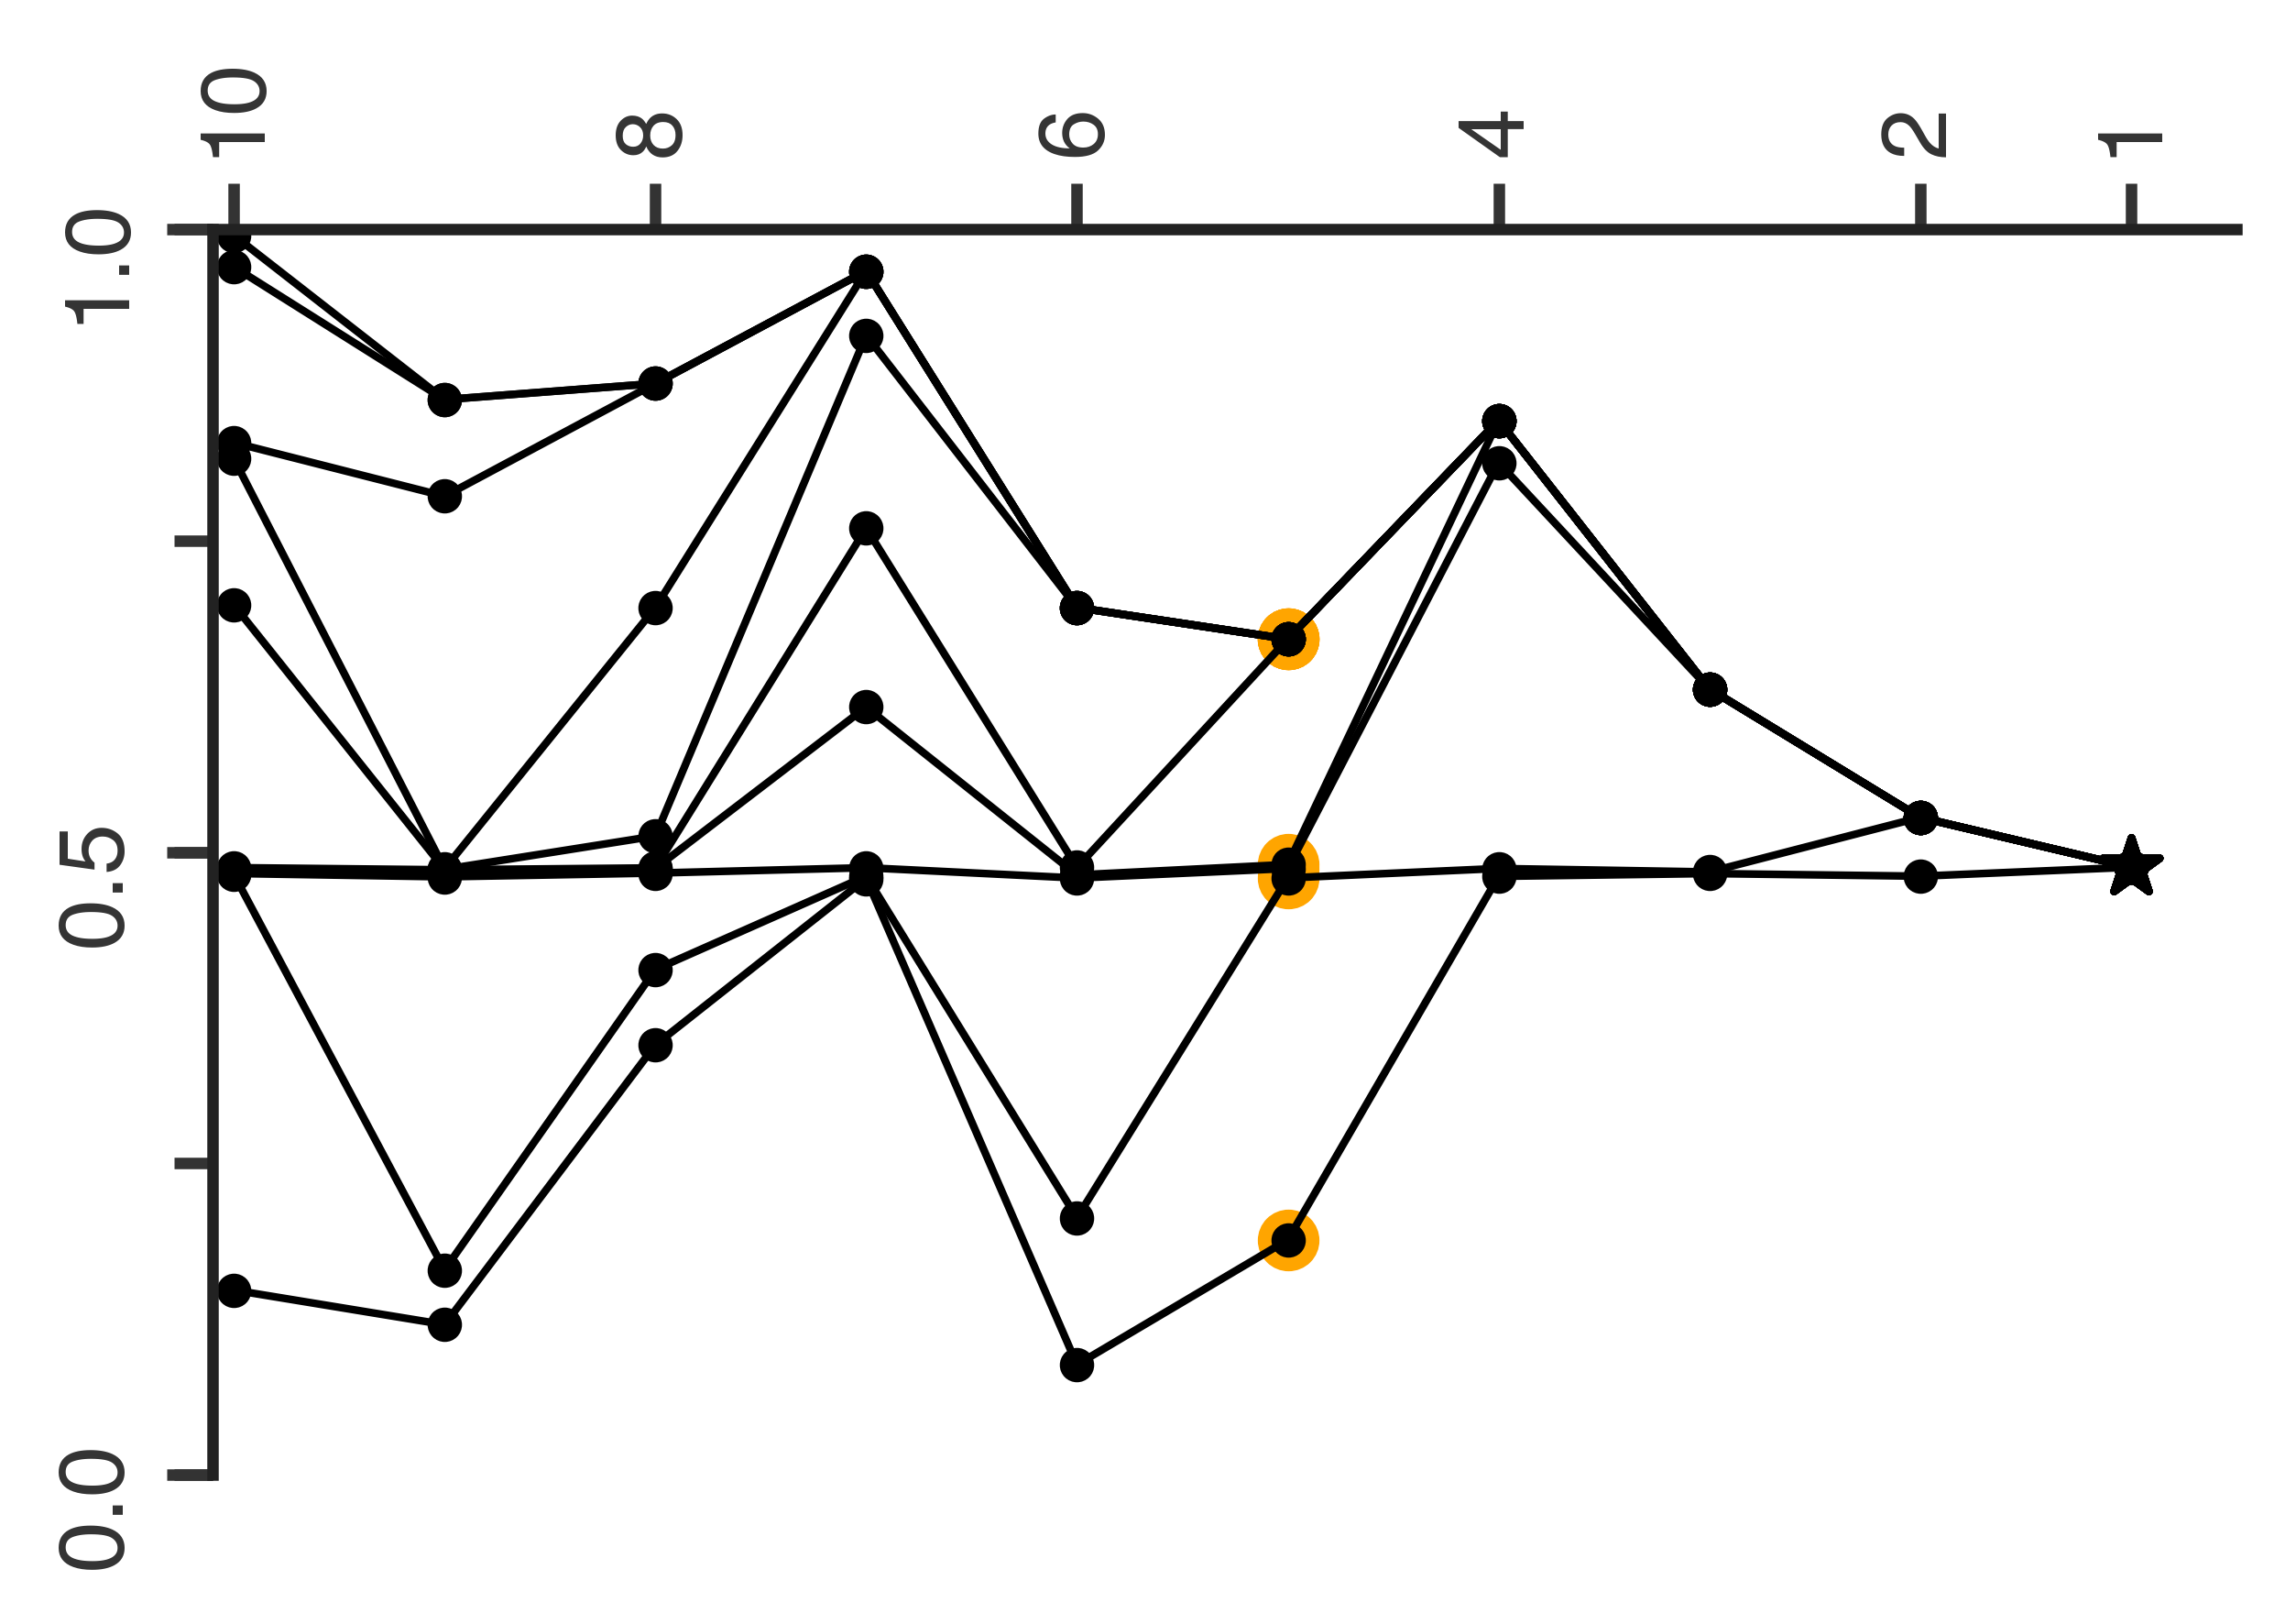

In [131]:
fig = plt.figure(figsize=(4.75, 3))
for depth in range(len(single_optimal_dict['sorted_optimal_cws'][-1])):
    this_series = []
    for num_filt in range(len(single_optimal_dict['sorted_optimal_cws'])):
        index = np.min([len(single_optimal_dict['sorted_optimal_cws'][num_filt]) - 1, depth])
        this_series.append(single_optimal_dict['sorted_optimal_cws'][num_filt][index])
    plt.plot(np.arange(1, 11), this_series, 'k', marker='.', markersize=8, linewidth=1)
    
    plt.scatter(1, this_series[0], marker='*', color='k', s=60)
    plt.scatter(5, this_series[4], color='orange', s=50)
# plt.ylabel('Center (1 - surround) \n weight', fontsize=20)
# plt.xlabel('Number of Filters', fontsize=20)
plt.xlim(10.1, 0.5)
plt.ylim(0, 1.0)

majorLocator = MultipleLocator(0.5)
majorLocatorx = MultipleLocator(2)
majorFormatter = FormatStrFormatter('%0.1f')
majorFormatterx = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_major_locator(majorLocatorx)
ax.xaxis.set_major_formatter(majorFormatterx)
ax.yaxis.set_minor_locator(minorLocator)
plt.xticks([1, 2, 4, 6, 8, 10], rotation=90)

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# # ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('top')
ax = plt.gca()
ax.xaxis.tick_top()
plt.xticks([1, 2, 4, 6, 8, 10], rotation=90)
plt.yticks([0.0, 0.5, 1.0], rotation=90)


# adjust_spines(plt.gca())
plt.savefig('2018_2_17_cws_vs_filters.png')

In [95]:
info_map_dict = dd.io.load('2018_2_17_info_map.h5')

In [96]:
info_map = info_map_dict['info_map']
all_cws = info_map_dict['all_cws']
all_hws = info_map_dict['all_hws']

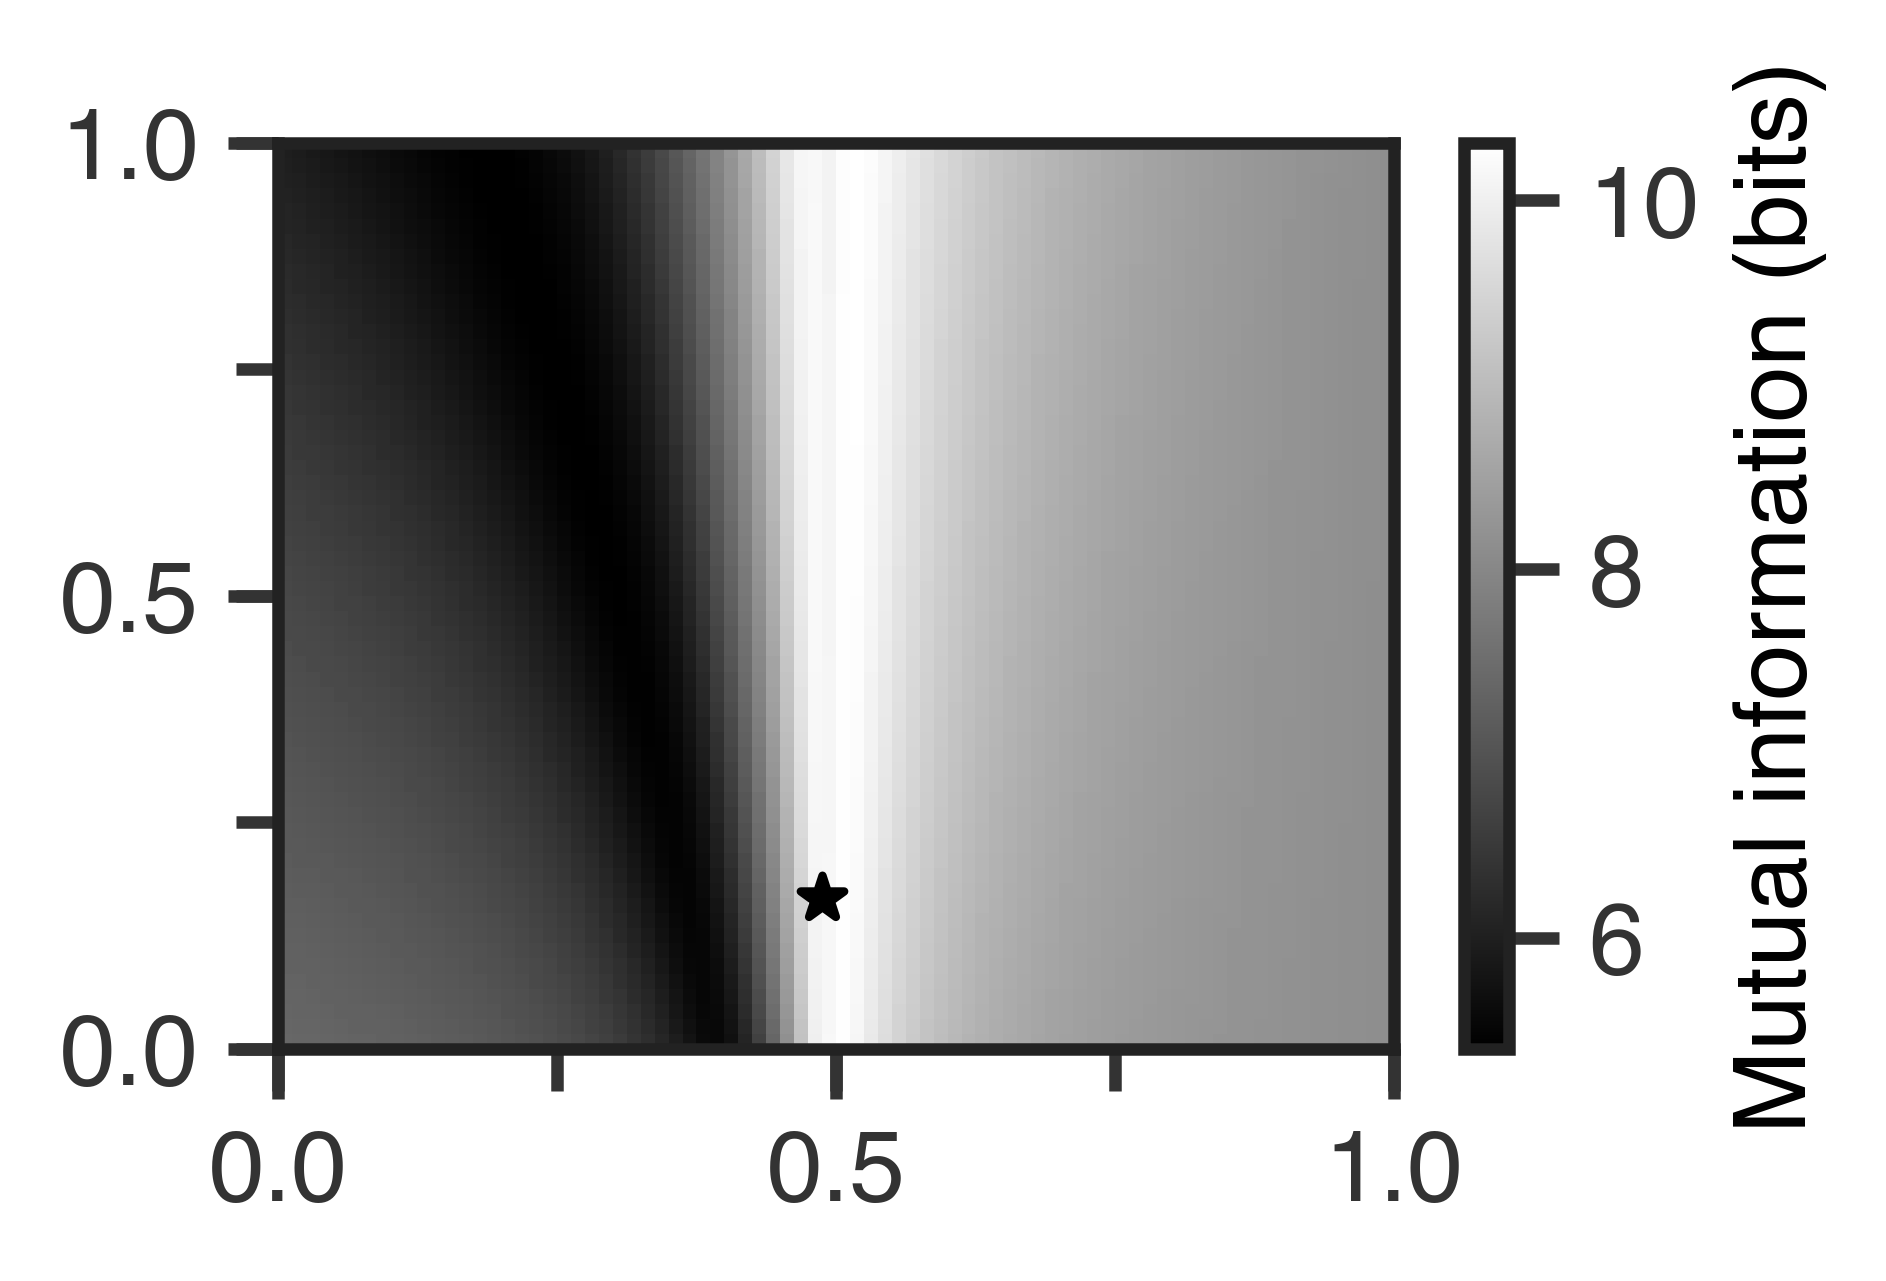

In [112]:
fig = plt.figure(figsize=(3, 2))
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=12)
plt.ylim([0,1])

plt.scatter(single_optimal_dict['sorted_optimal_cws'][0][0],
            single_optimal_dict['sorted_optimal_hws'][0][0], 
            color='k', marker='*', s=30)

majorLocator = MultipleLocator(0.5)
majorLocatorx = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
majorFormatterx = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_major_locator(majorLocatorx)
ax.xaxis.set_major_formatter(majorFormatterx)
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)


plt.savefig('2018_2_17 info map.png', transparent=True)

In [23]:
constants = np.load(os.path.expanduser('~/data/surround/2017_10_9_diversity_constants.npy')).item()
signal = np.array(np.load(os.path.expanduser('~/data/surround/signal_3_23.npy')))

In [24]:
def generate_spatial_signals(batch_size, signal=signal):
    # We generate white noise sequences, then multiply their frequency spectra
    # by the signal frequency spectra to make it look like a natural sequence.
    random_seq = [np.random.randn(2 * len(signal) - 1) for b in range(batch_size)]
    spatial_seq = [np.fft.irfft(np.fft.rfft(s) * signal) for s in random_seq]
    return np.stack(spatial_seq)

In [25]:
spatial_signals = generate_spatial_signals(1000)
spatial_signals.shape

(1000, 398)

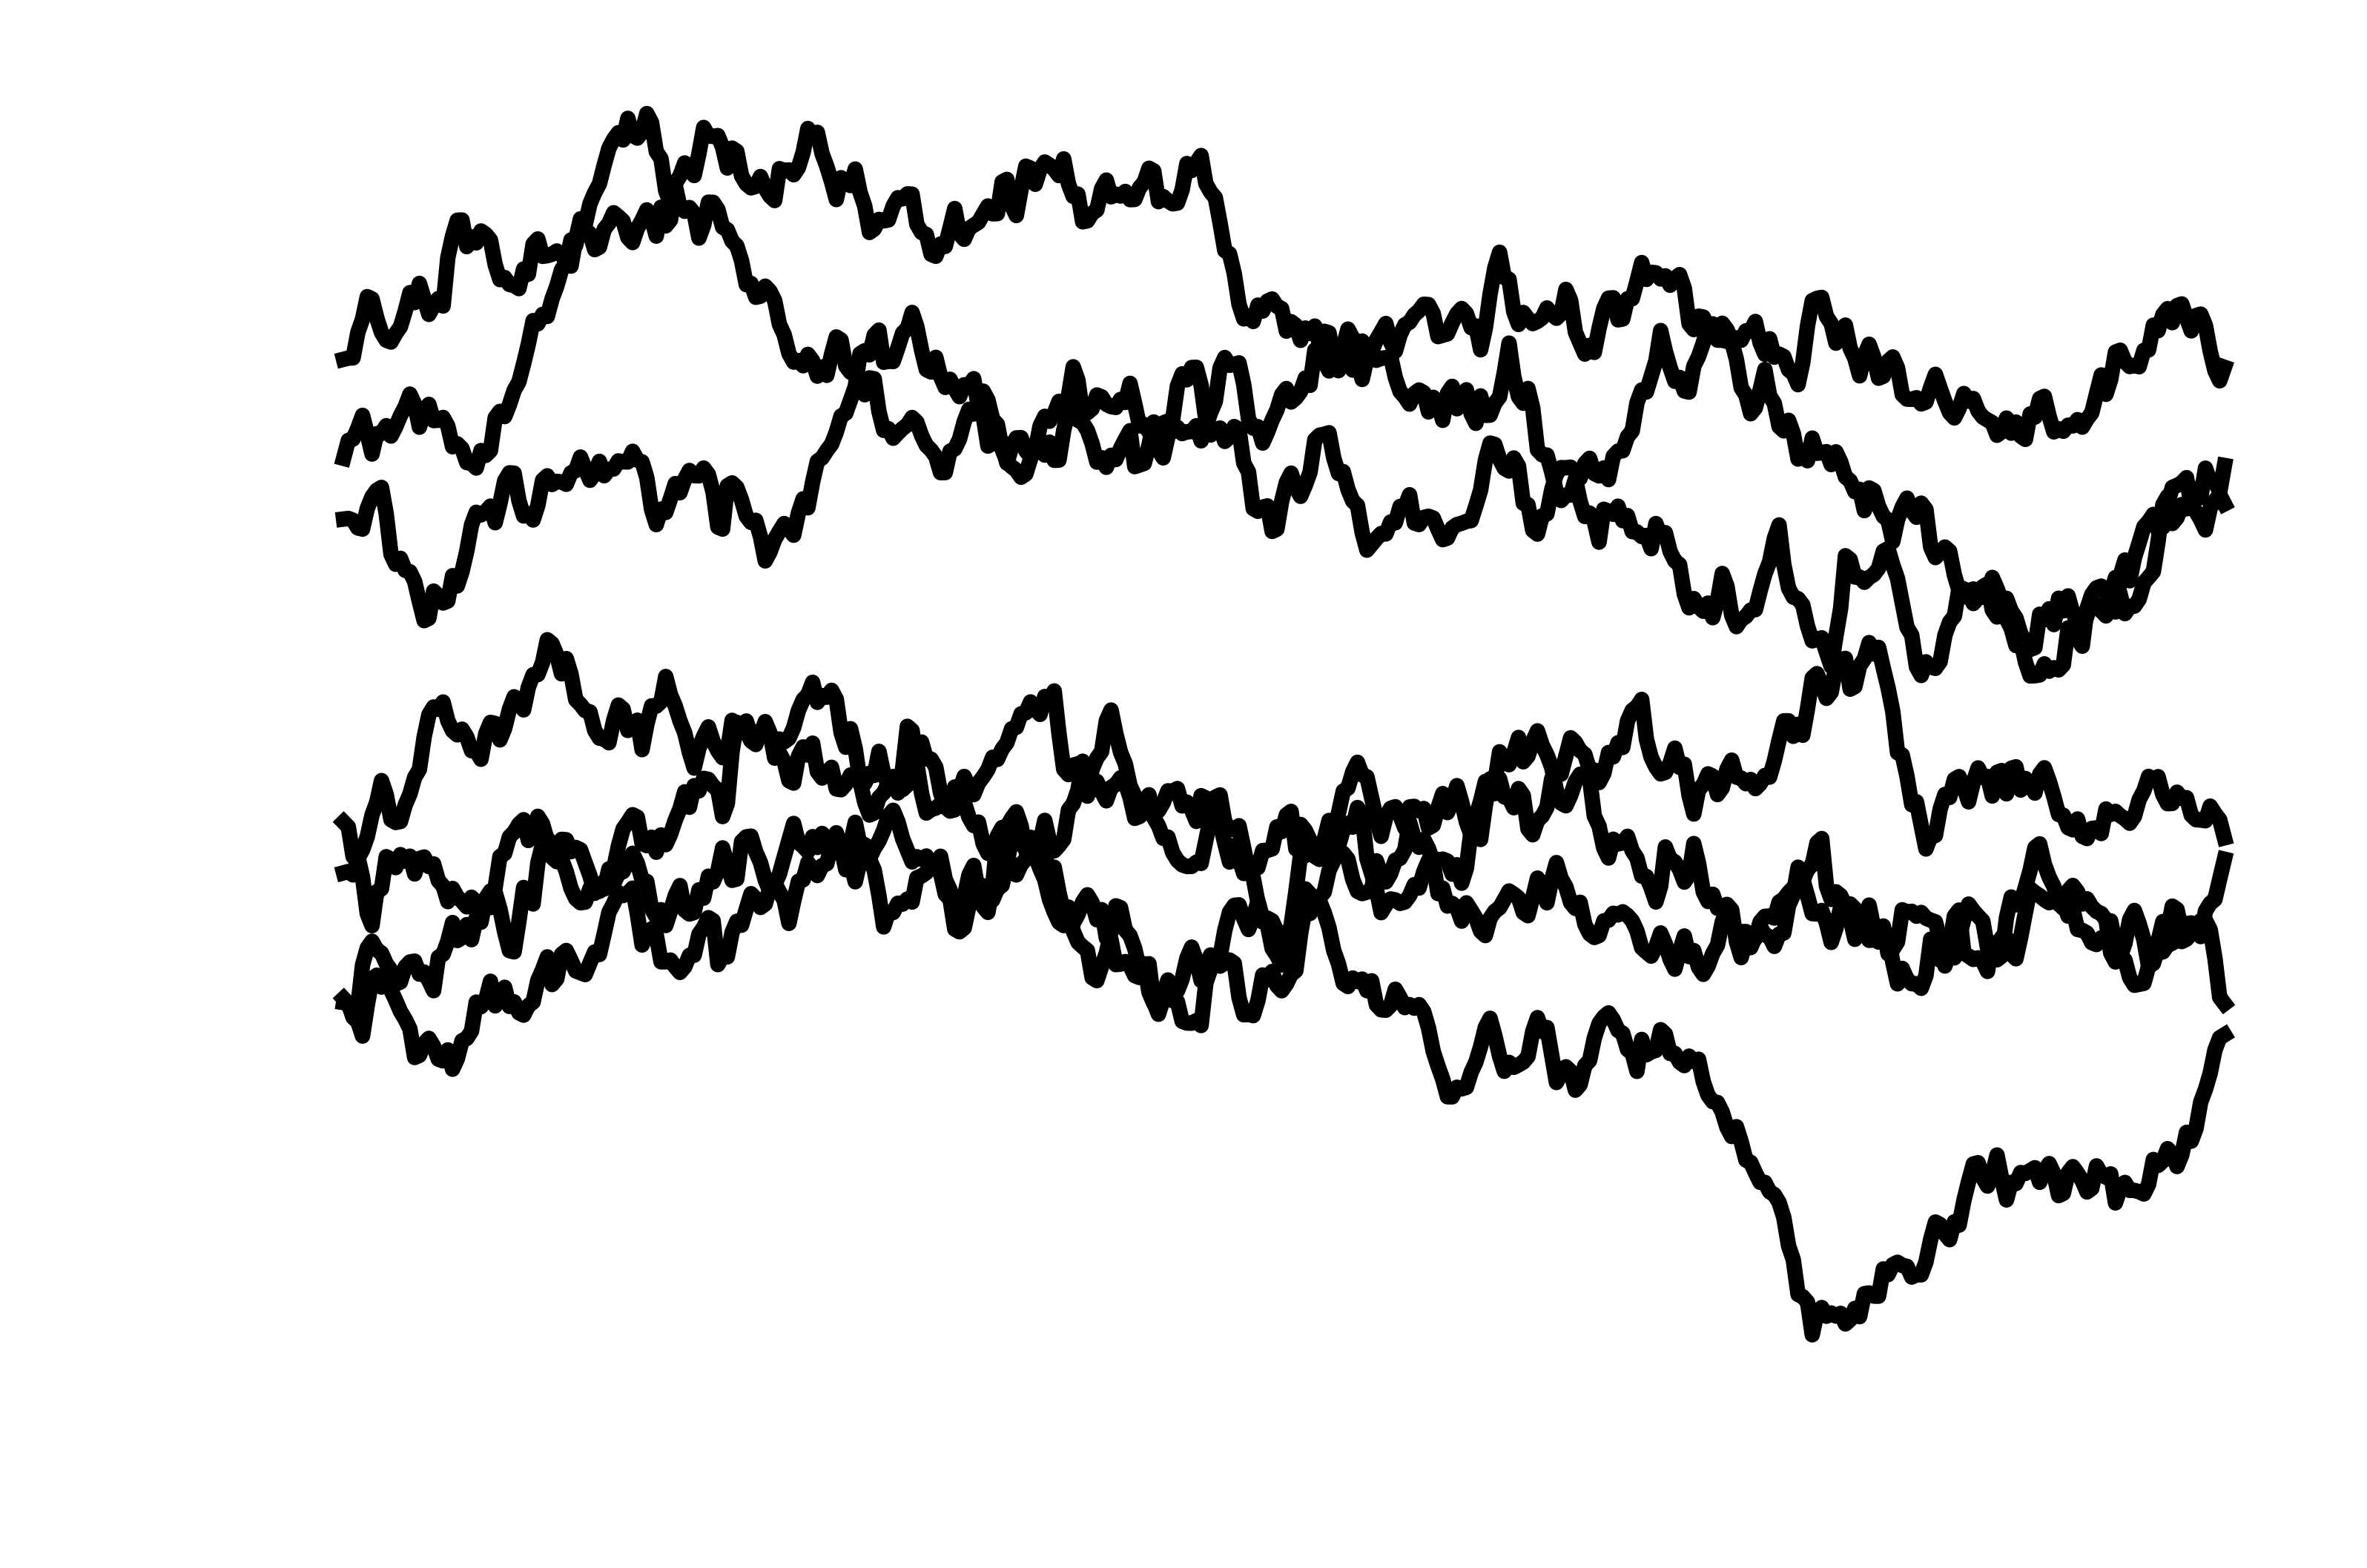

In [26]:
plt.plot(spatial_signals[:7, :].T, color='k')
ax = plt.gca()
ax.axis('off');
plt.savefig('2018_2_17_spatial_signals.png')

In [27]:
def rf_model(horz_weight, center_weight):
    return center_weight*constants['center'] + (1-center_weight)*(
        horz_weight*constants['horz_pf'] + (1-horz_weight)*constants['ama_pf'])

In [28]:
def filter_bank(hws, cws):
    filters_sparse = []
    for hw, cw in zip(hws, cws):
        rf_1d = rf_model(hw, cw)
        t = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d)
        t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d[::-1])[::-1, ::-1]
        filters = np.vstack([t_rev, t])[200:-200]
        filters_sparse.append(filters[40:-30:50])
    return np.vstack(filters_sparse)

In [29]:
f = filter_bank([0.2, 0.4], [0.6, 0.7])

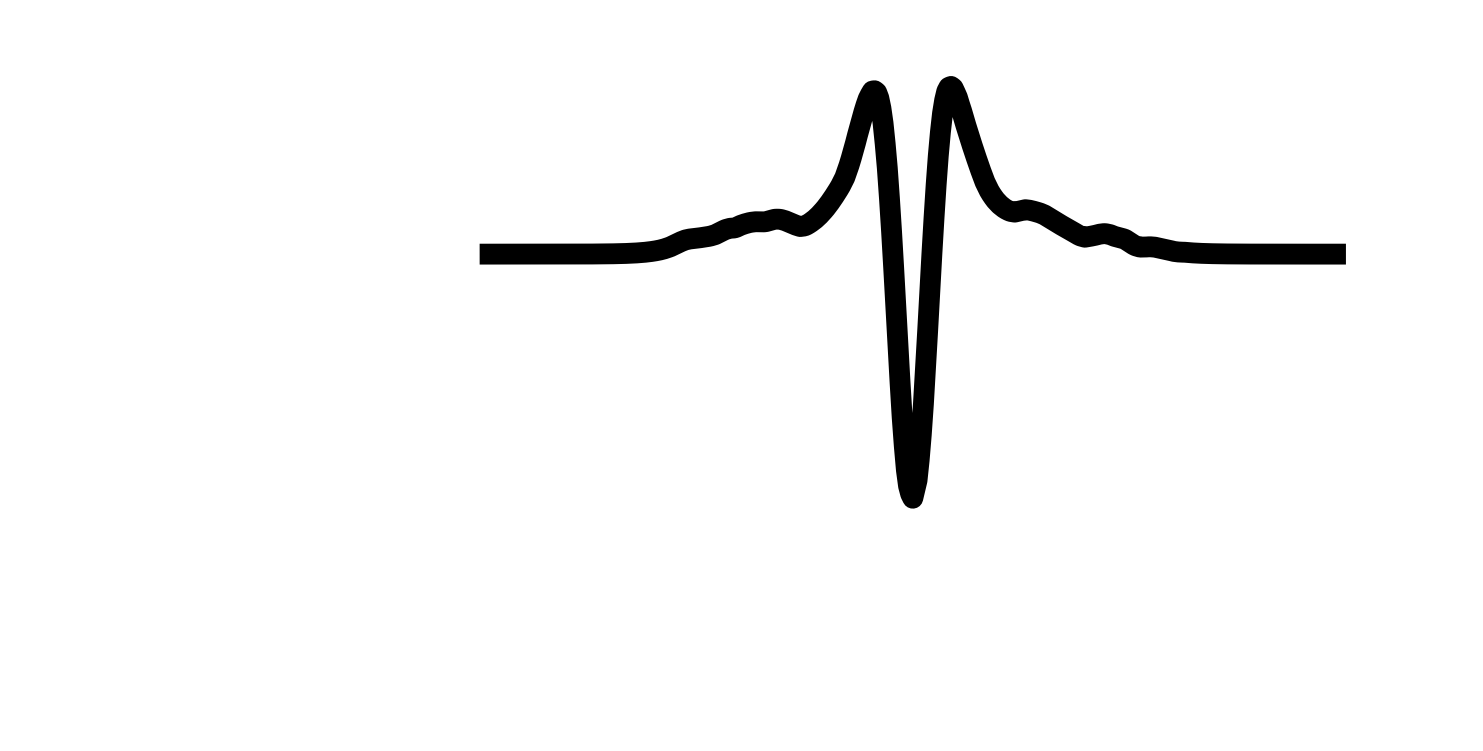

In [30]:
fig = plt.figure(figsize=(2,1))
rf_1d = rf_model(0.2, 0.4)
plt.plot(rf_1d, color='k')
ax = plt.gca()
ax.axis('off');

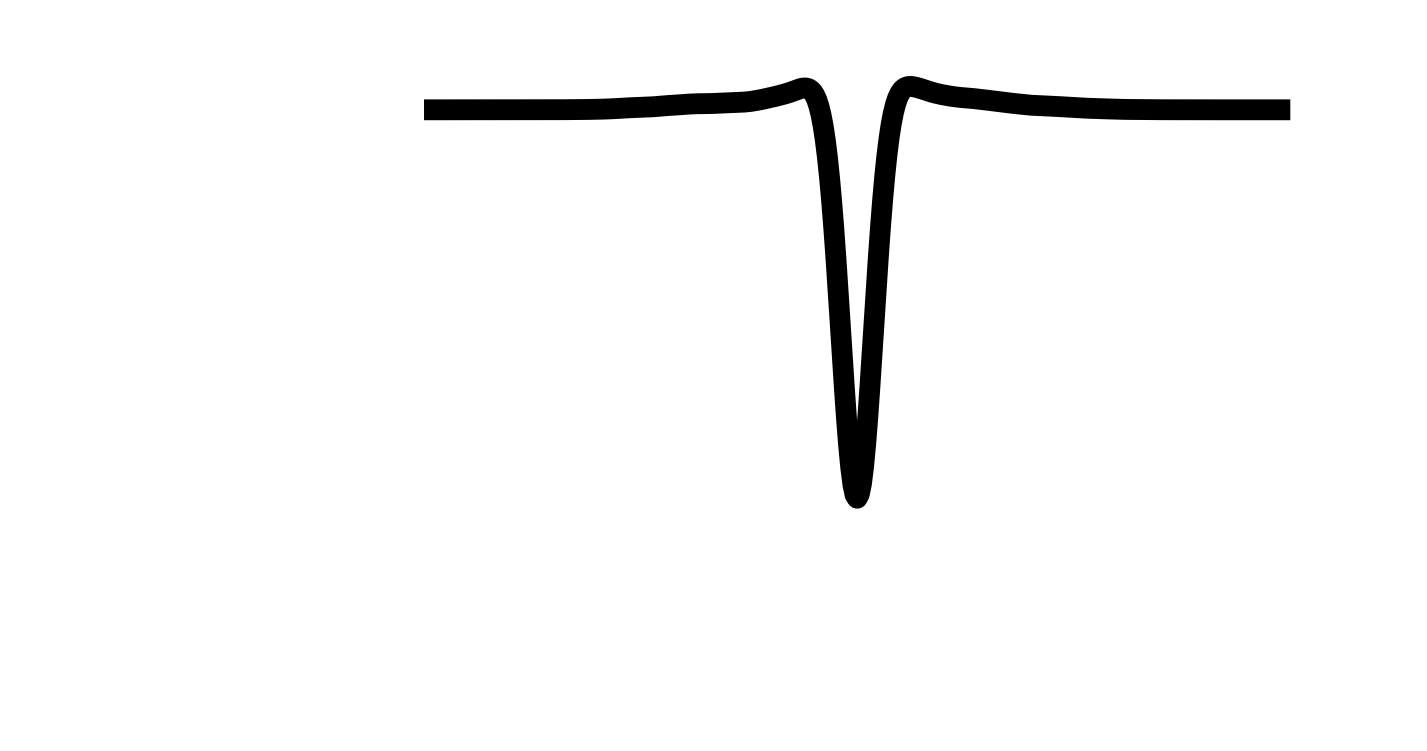

In [31]:
fig = plt.figure(figsize=(2,1))
rf_1d = rf_model(0.6, 0.7)
plt.plot(rf_1d, color='k')
ax = plt.gca()
ax.axis('off');

In [43]:
np.mean(np.diff(constants['space']))

0.20100502512562815

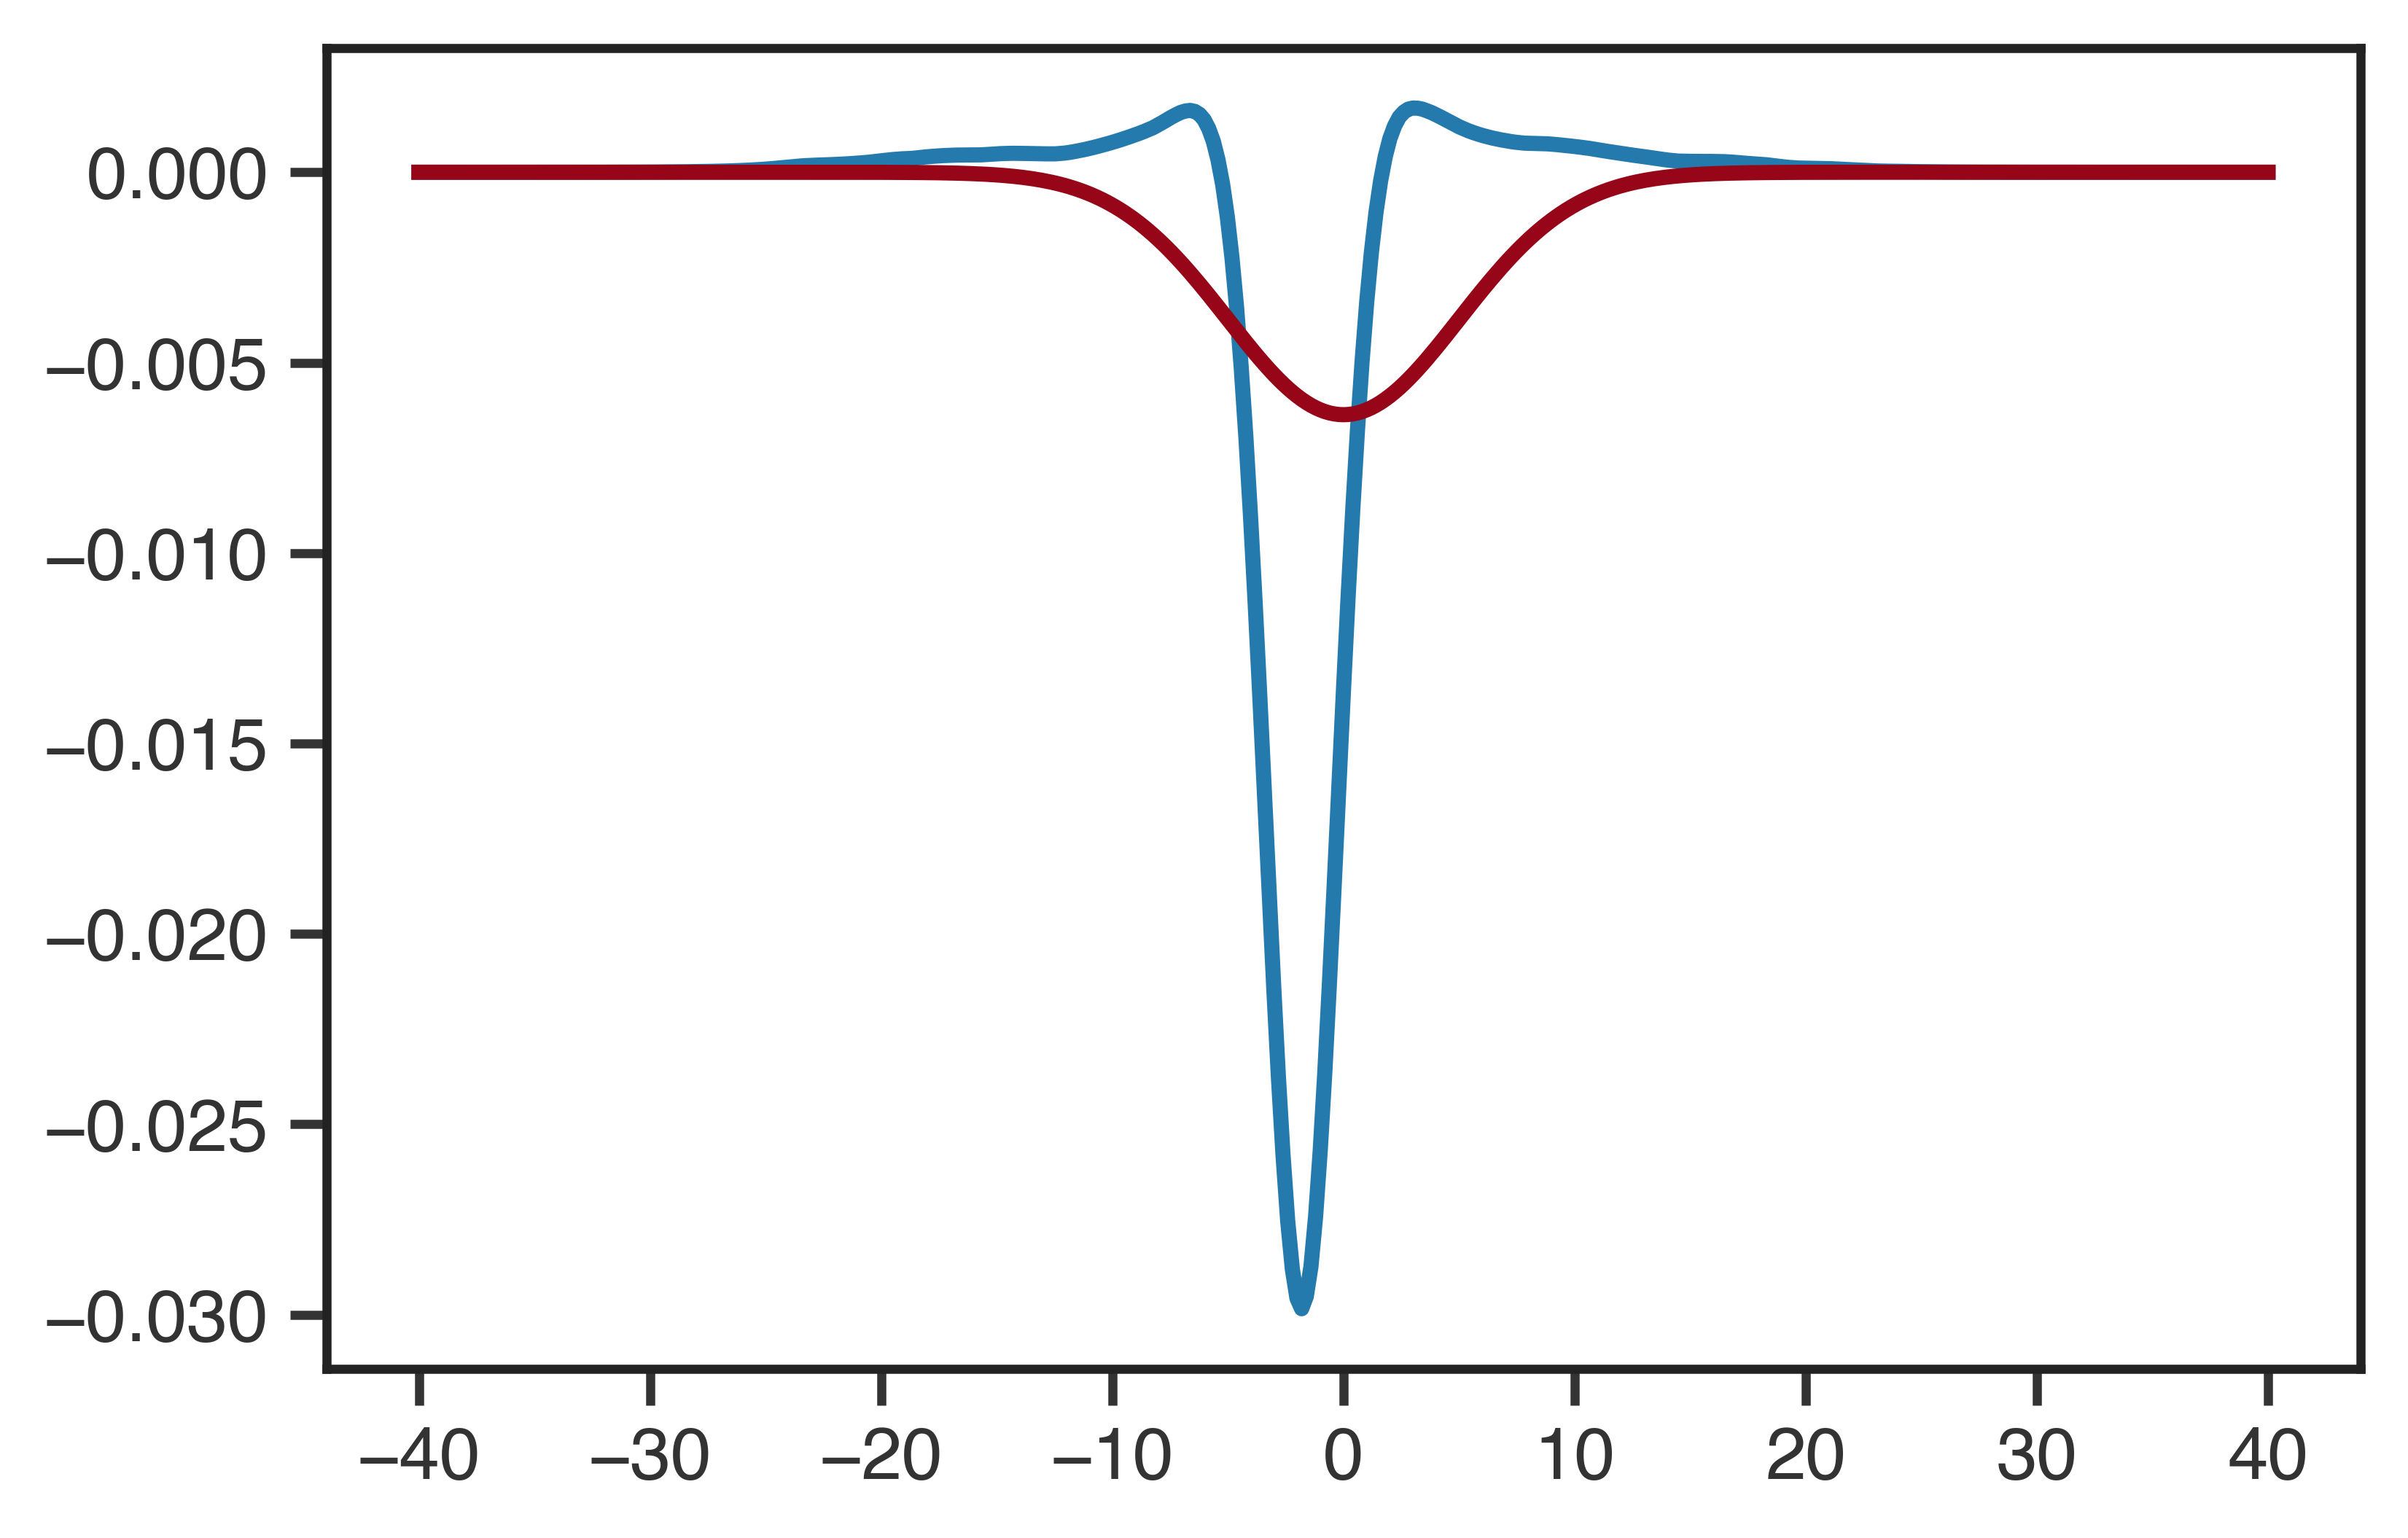

In [54]:
plt.plot(constants['space'], f[10])
plt.plot(constants['space'], -gaussian(x=constants['space'], sigma=5))

In [42]:
50.0 * np.mean(np.diff(constants['space']))

10.050251256281408

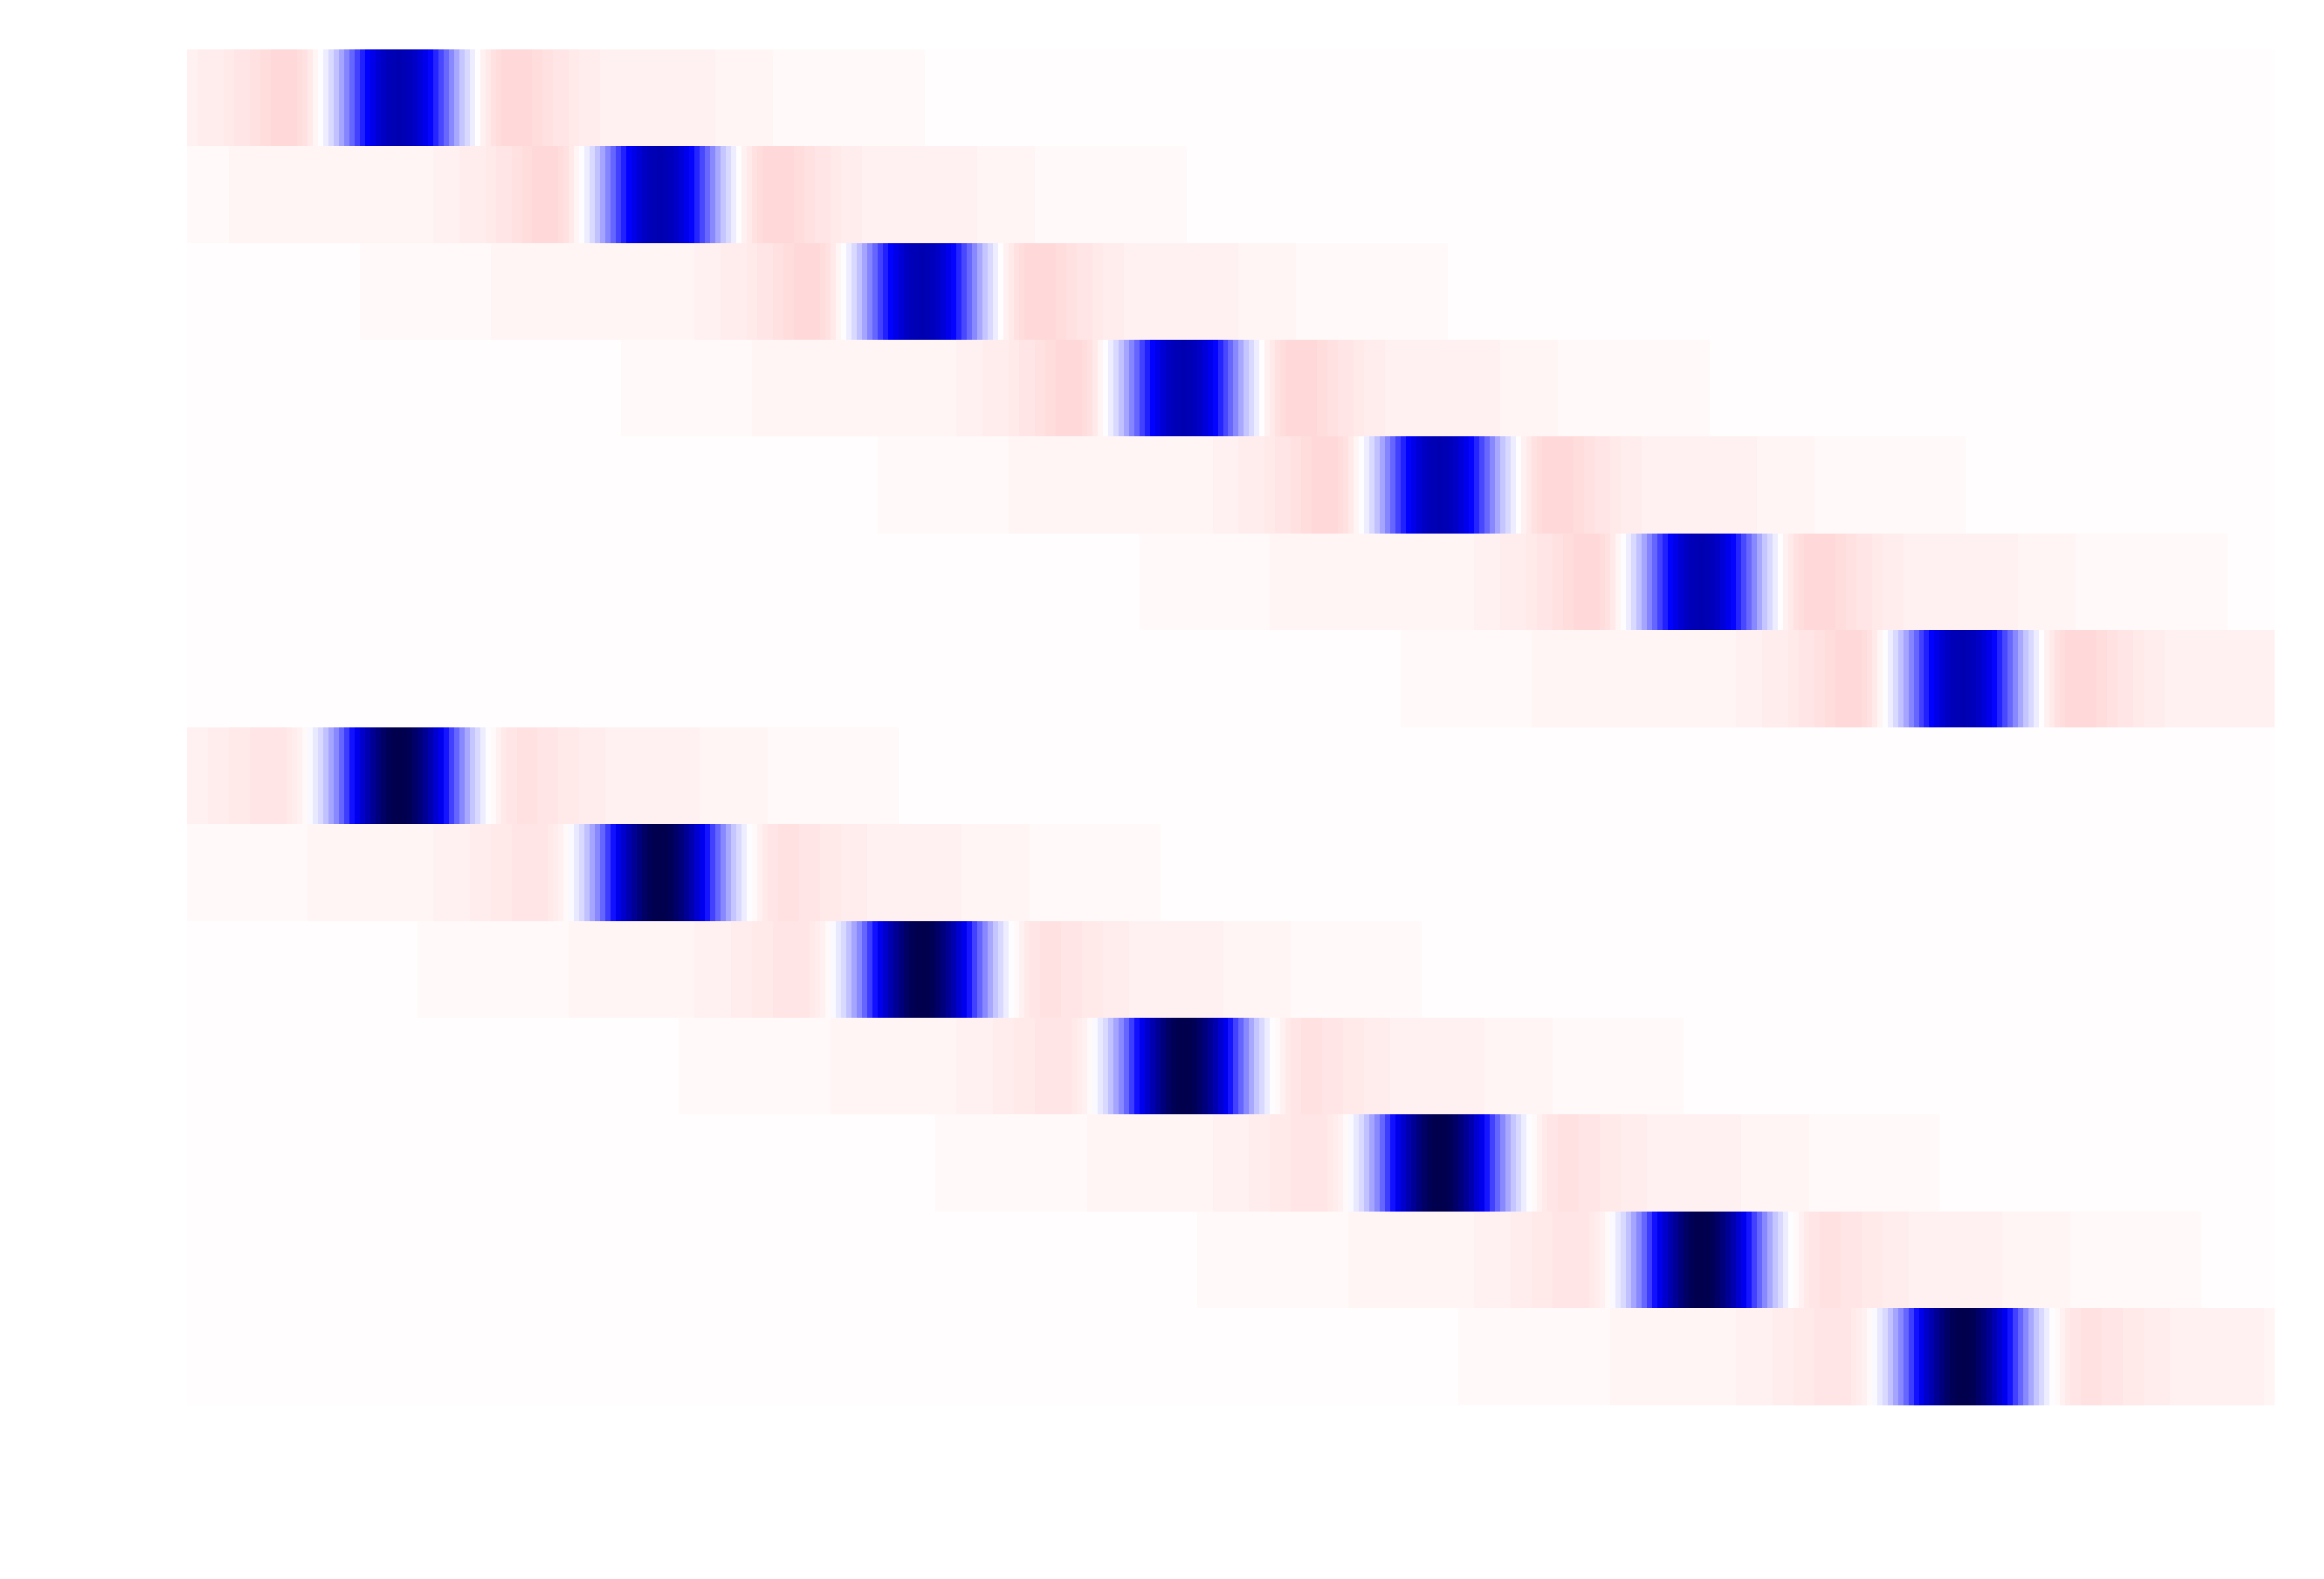

In [32]:
plt.imshow(f, aspect='auto', clim=[-np.max(abs(f)), np.max(abs(f))], cmap='seismic')
plt.grid('off')
ax = plt.gca()
ax.axis('off');

In [33]:
responses = np.dot(f[:, :-1], spatial_signals.T)
responses.shape

(14, 1000)

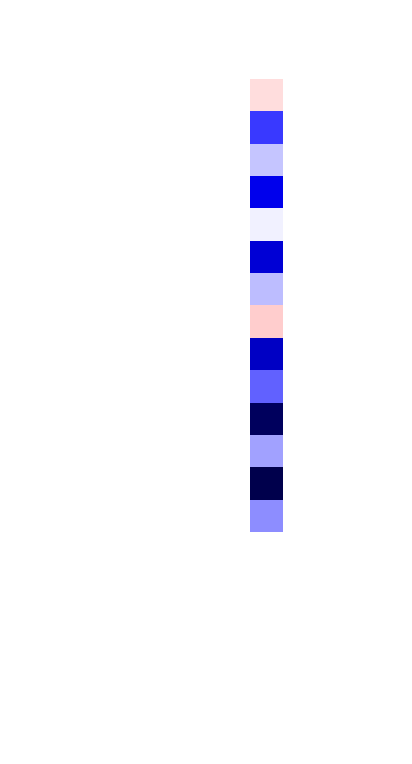

In [34]:
fig = plt.figure(figsize=(2,1))
r = np.expand_dims(responses[:, 900], 1)
plt.imshow(r, clim=[-np.max(abs(r)), np.max(abs(r))], cmap='seismic')
plt.grid('off')
ax = plt.gca()
ax.axis('off');

In [35]:
responses = np.dot(f[:, :-1], spatial_signals[:7, :].T)
responses.shape

(14, 7)

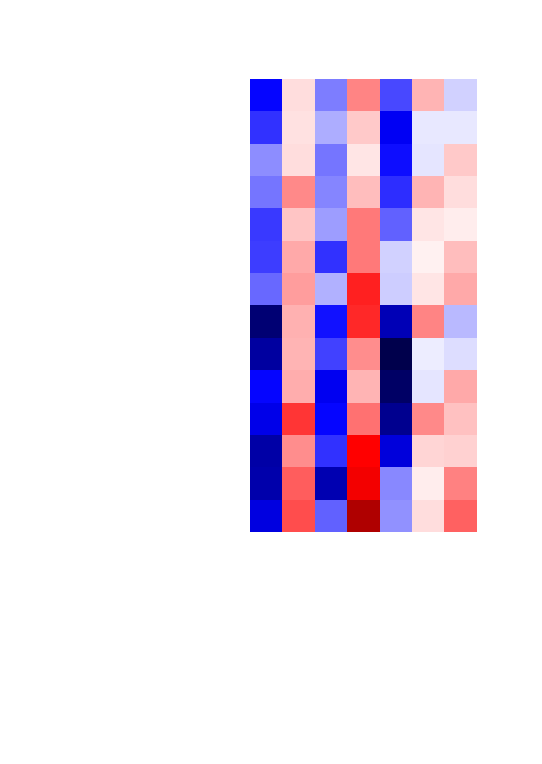

In [36]:
fig = plt.figure(figsize=(2,1))
r = responses
plt.imshow(r, clim=[-np.max(abs(r)), np.max(abs(r))], cmap='seismic')
plt.grid('off')
ax = plt.gca()
ax.axis('off');

In [55]:
space = constants['space']
center = constants['center']
horz_pf = constants['horz_pf']
ama_pf = constants['ama_pf']
input_noise = constants['input_noise']
output_noise = constants['output_noise']
target_power = constants['target_power']

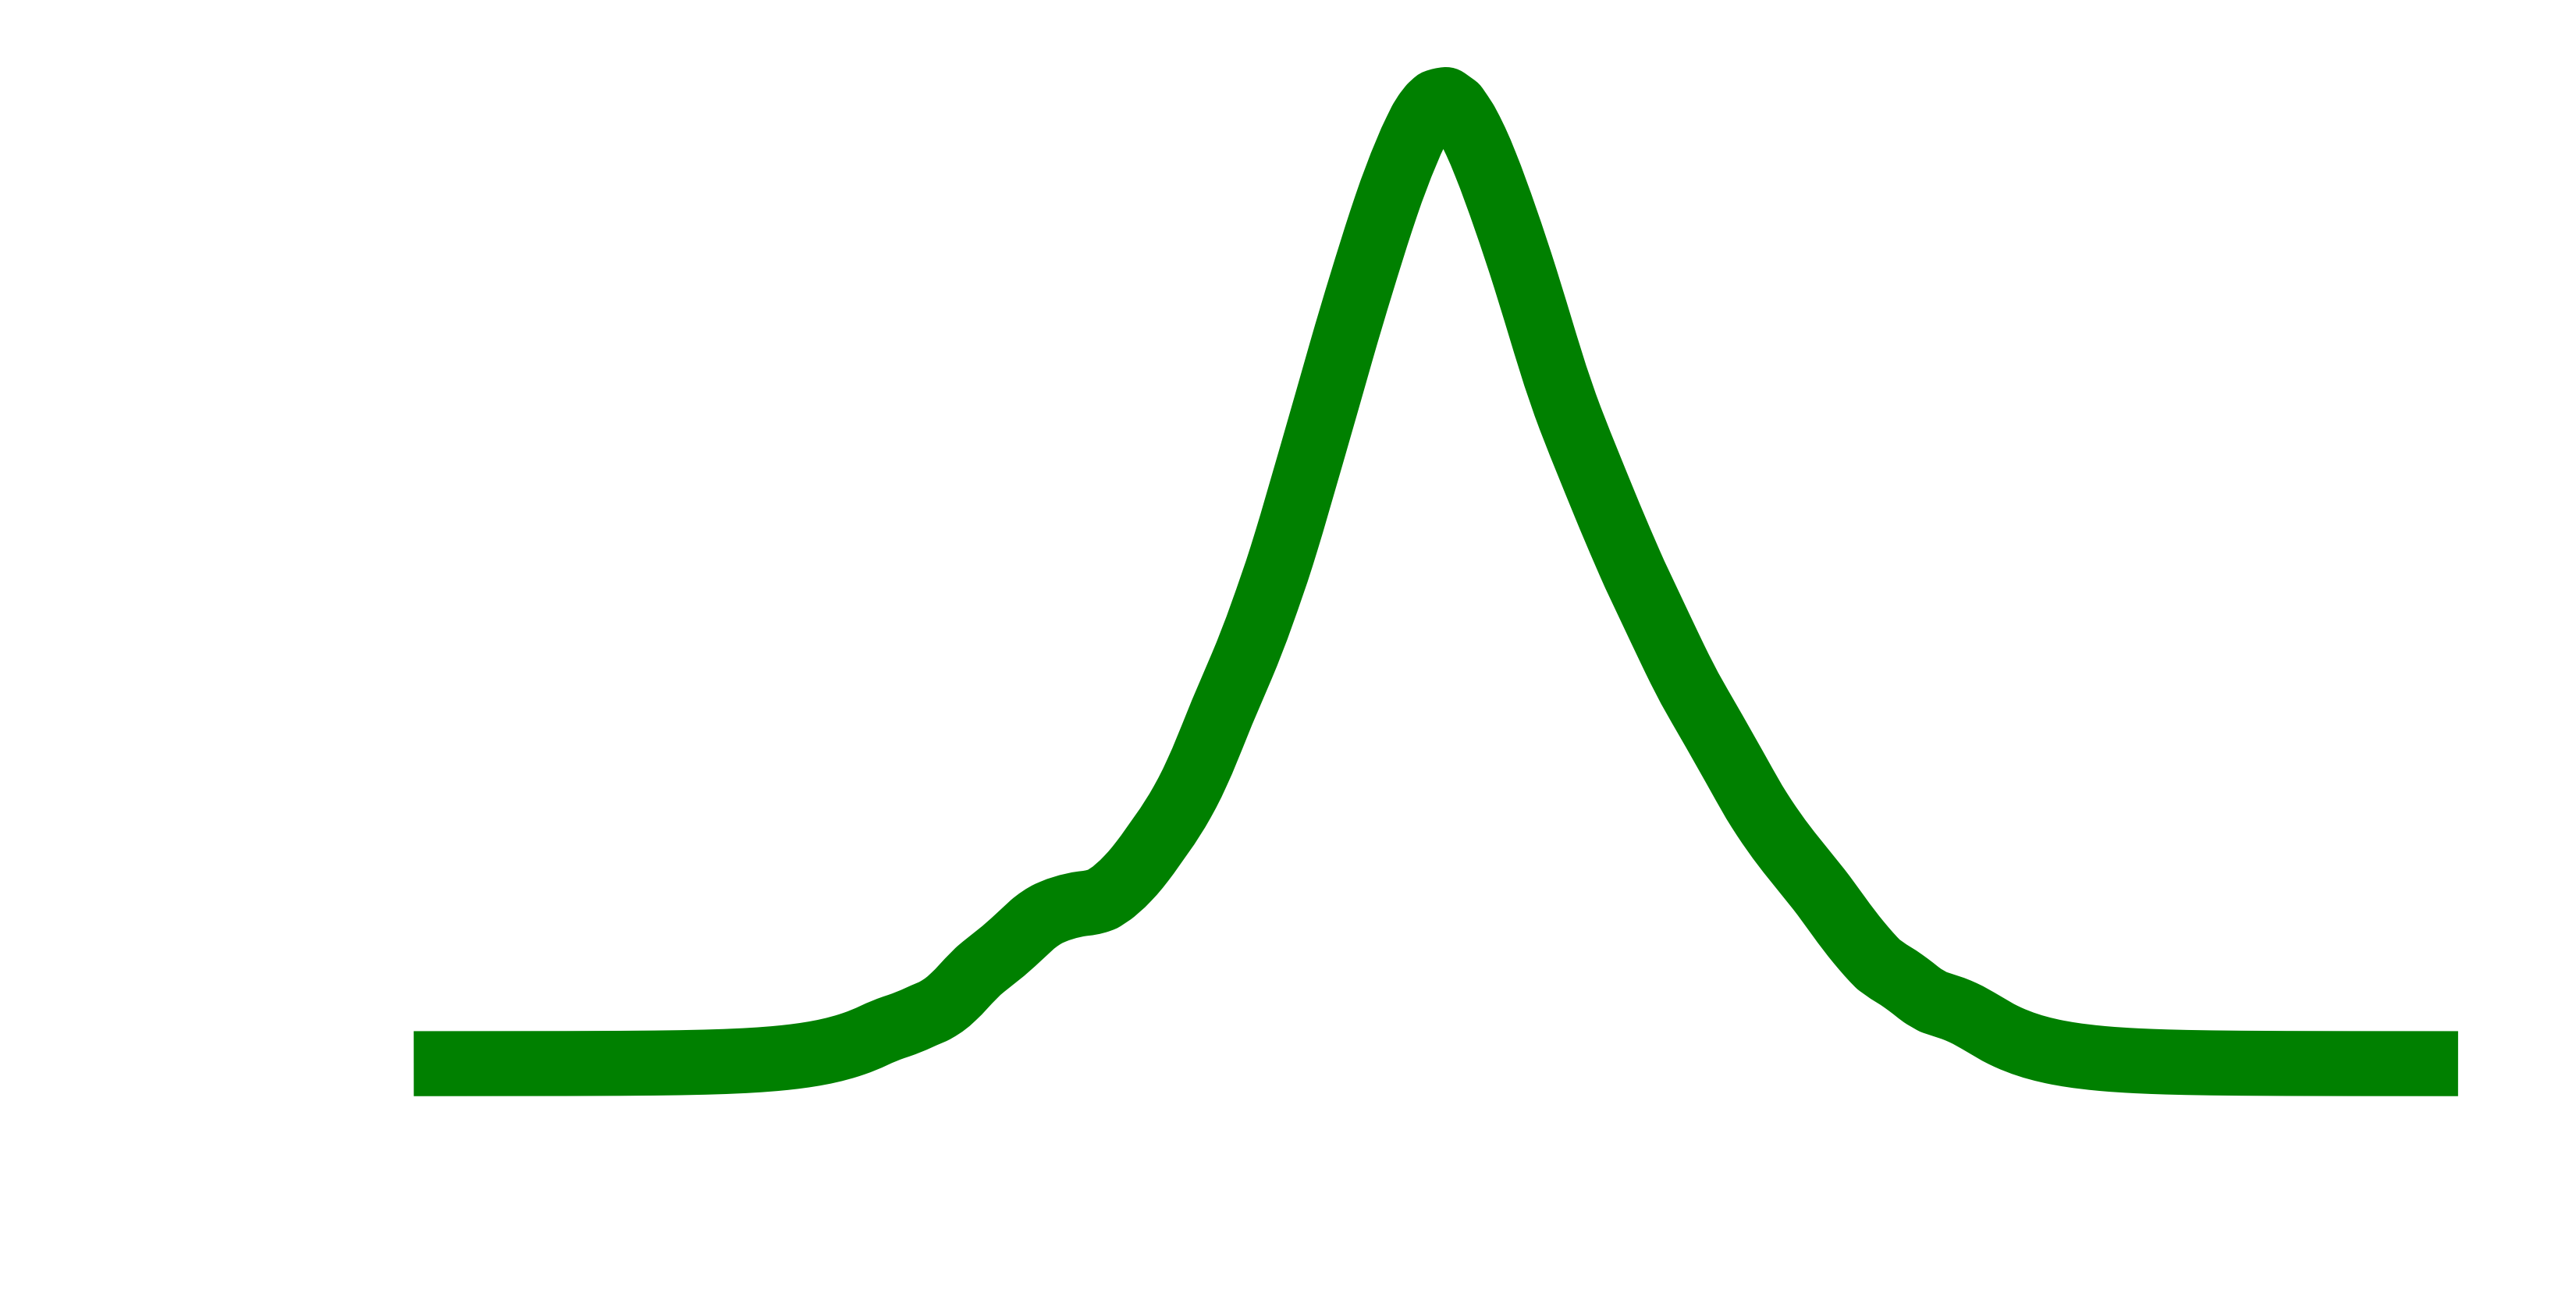

In [83]:
fig = plt.figure(figsize=(6, 3))
plt.plot(space, horz_pf, 'g', linewidth=10)
plt.axis('off')
plt.savefig('horizontal_pf.png', transparent=True)

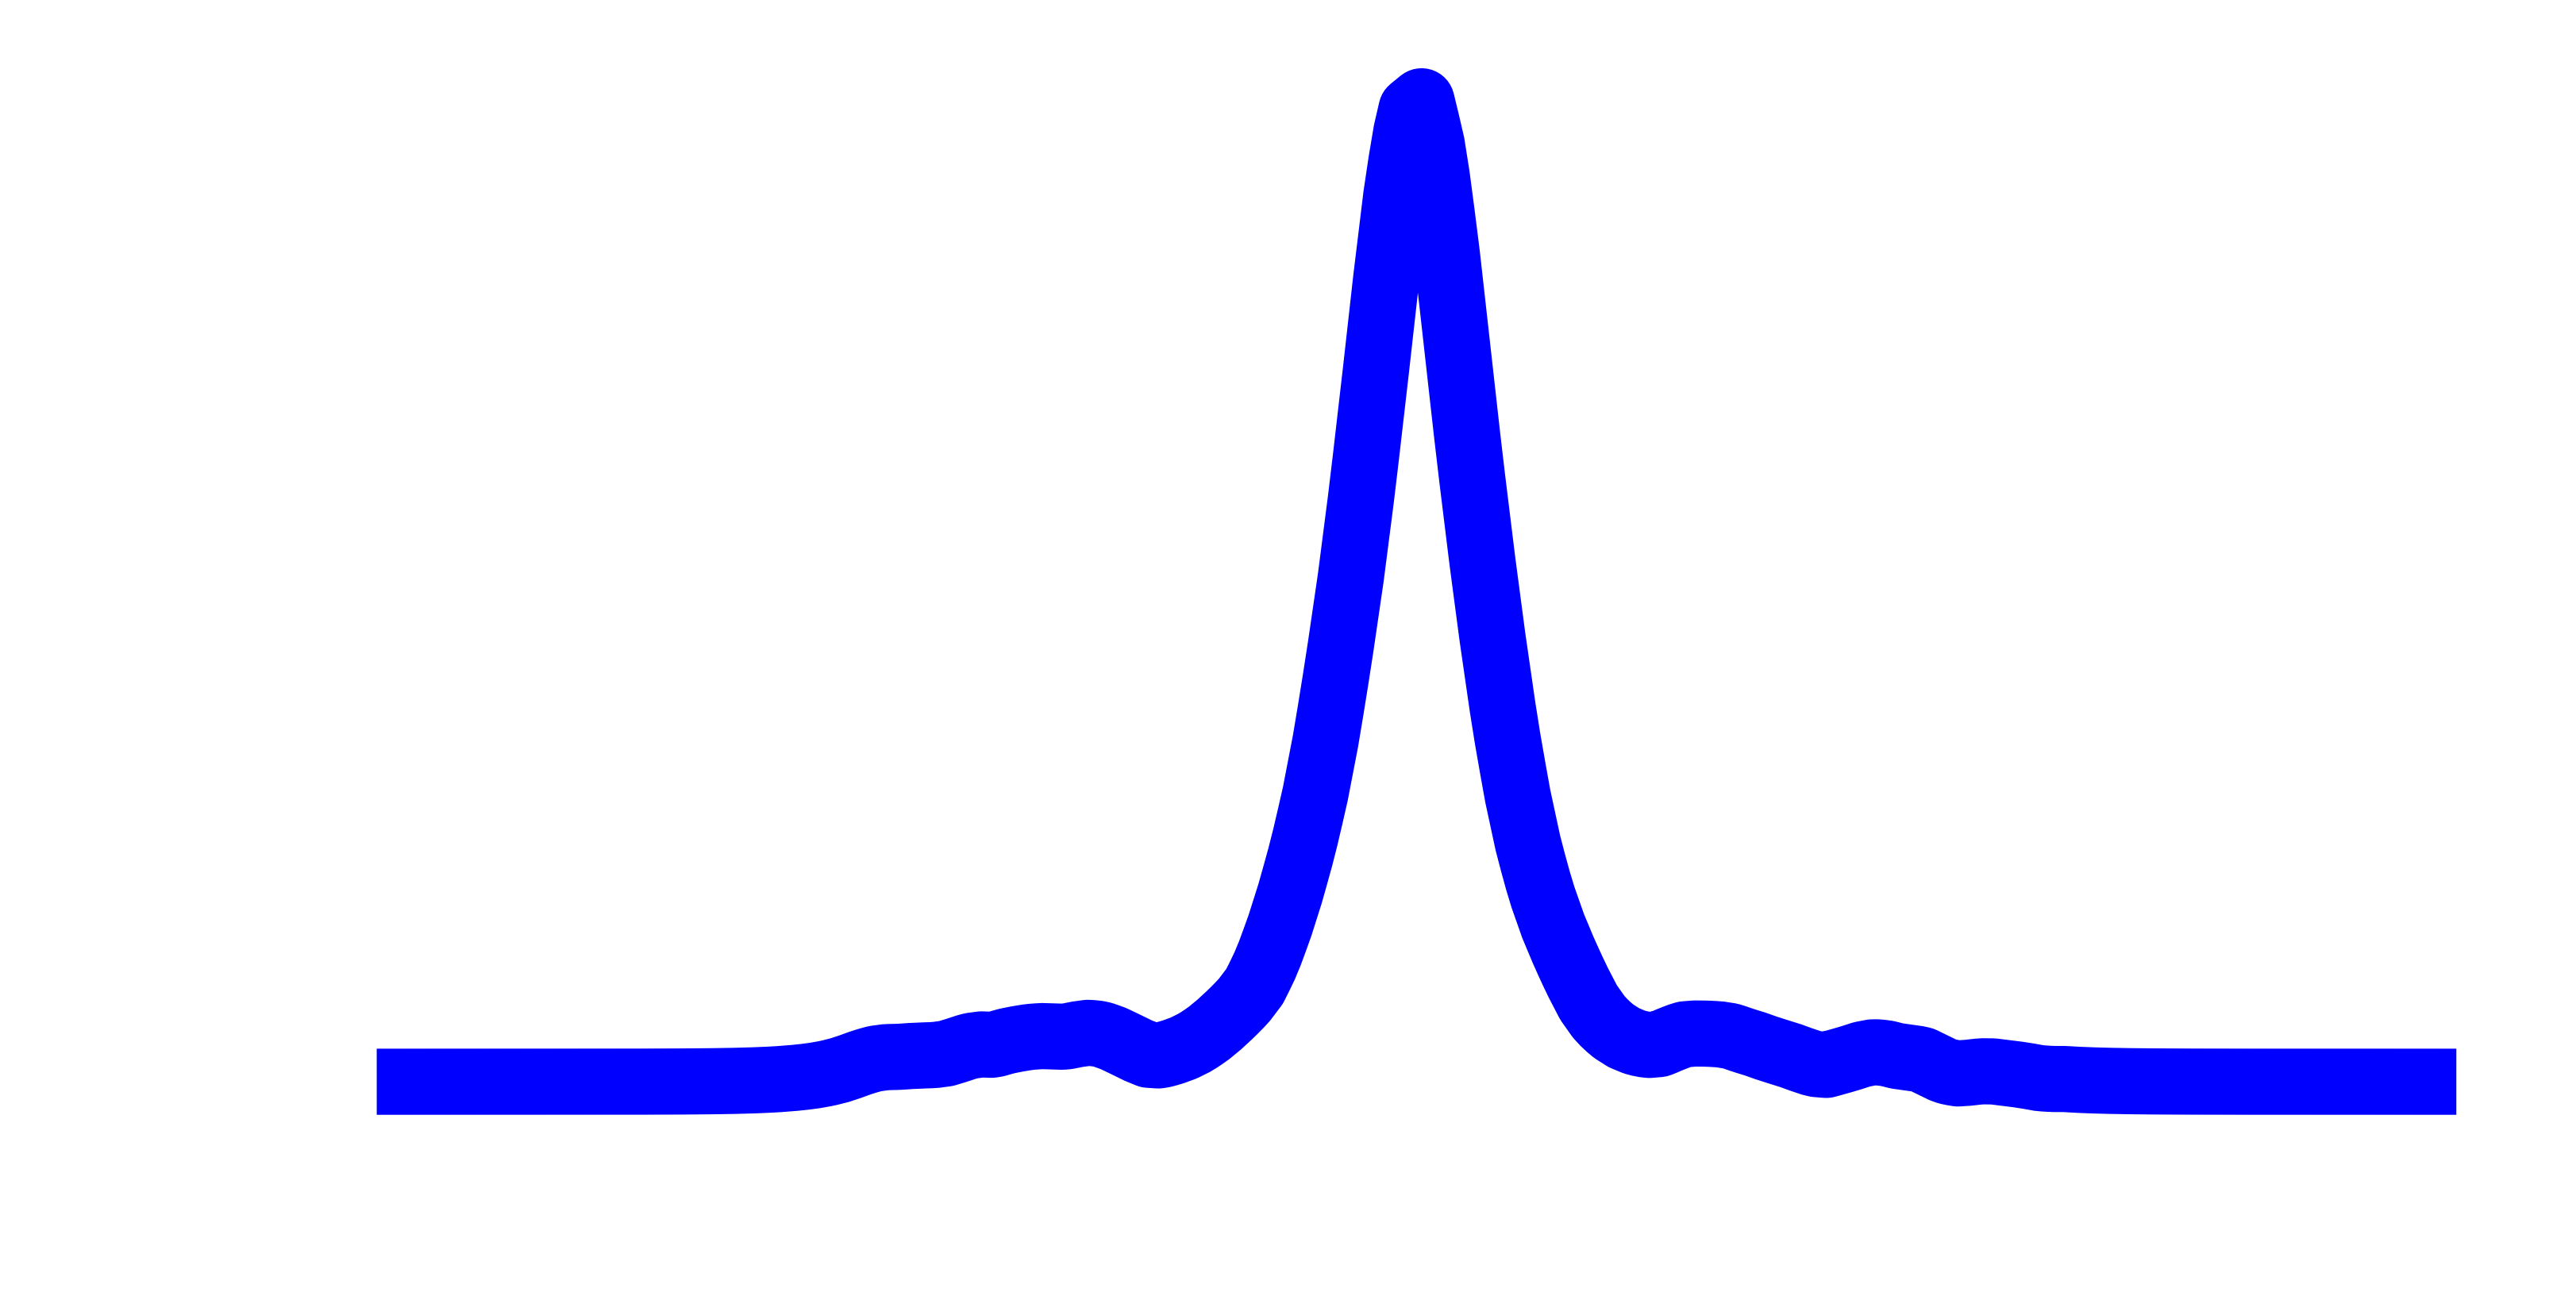

In [84]:
fig = plt.figure(figsize=(6, 3))
plt.plot(space, ama_pf, 'b', linewidth=10)
plt.axis('off')
plt.savefig('amacrine_pf.png', transparent=True)

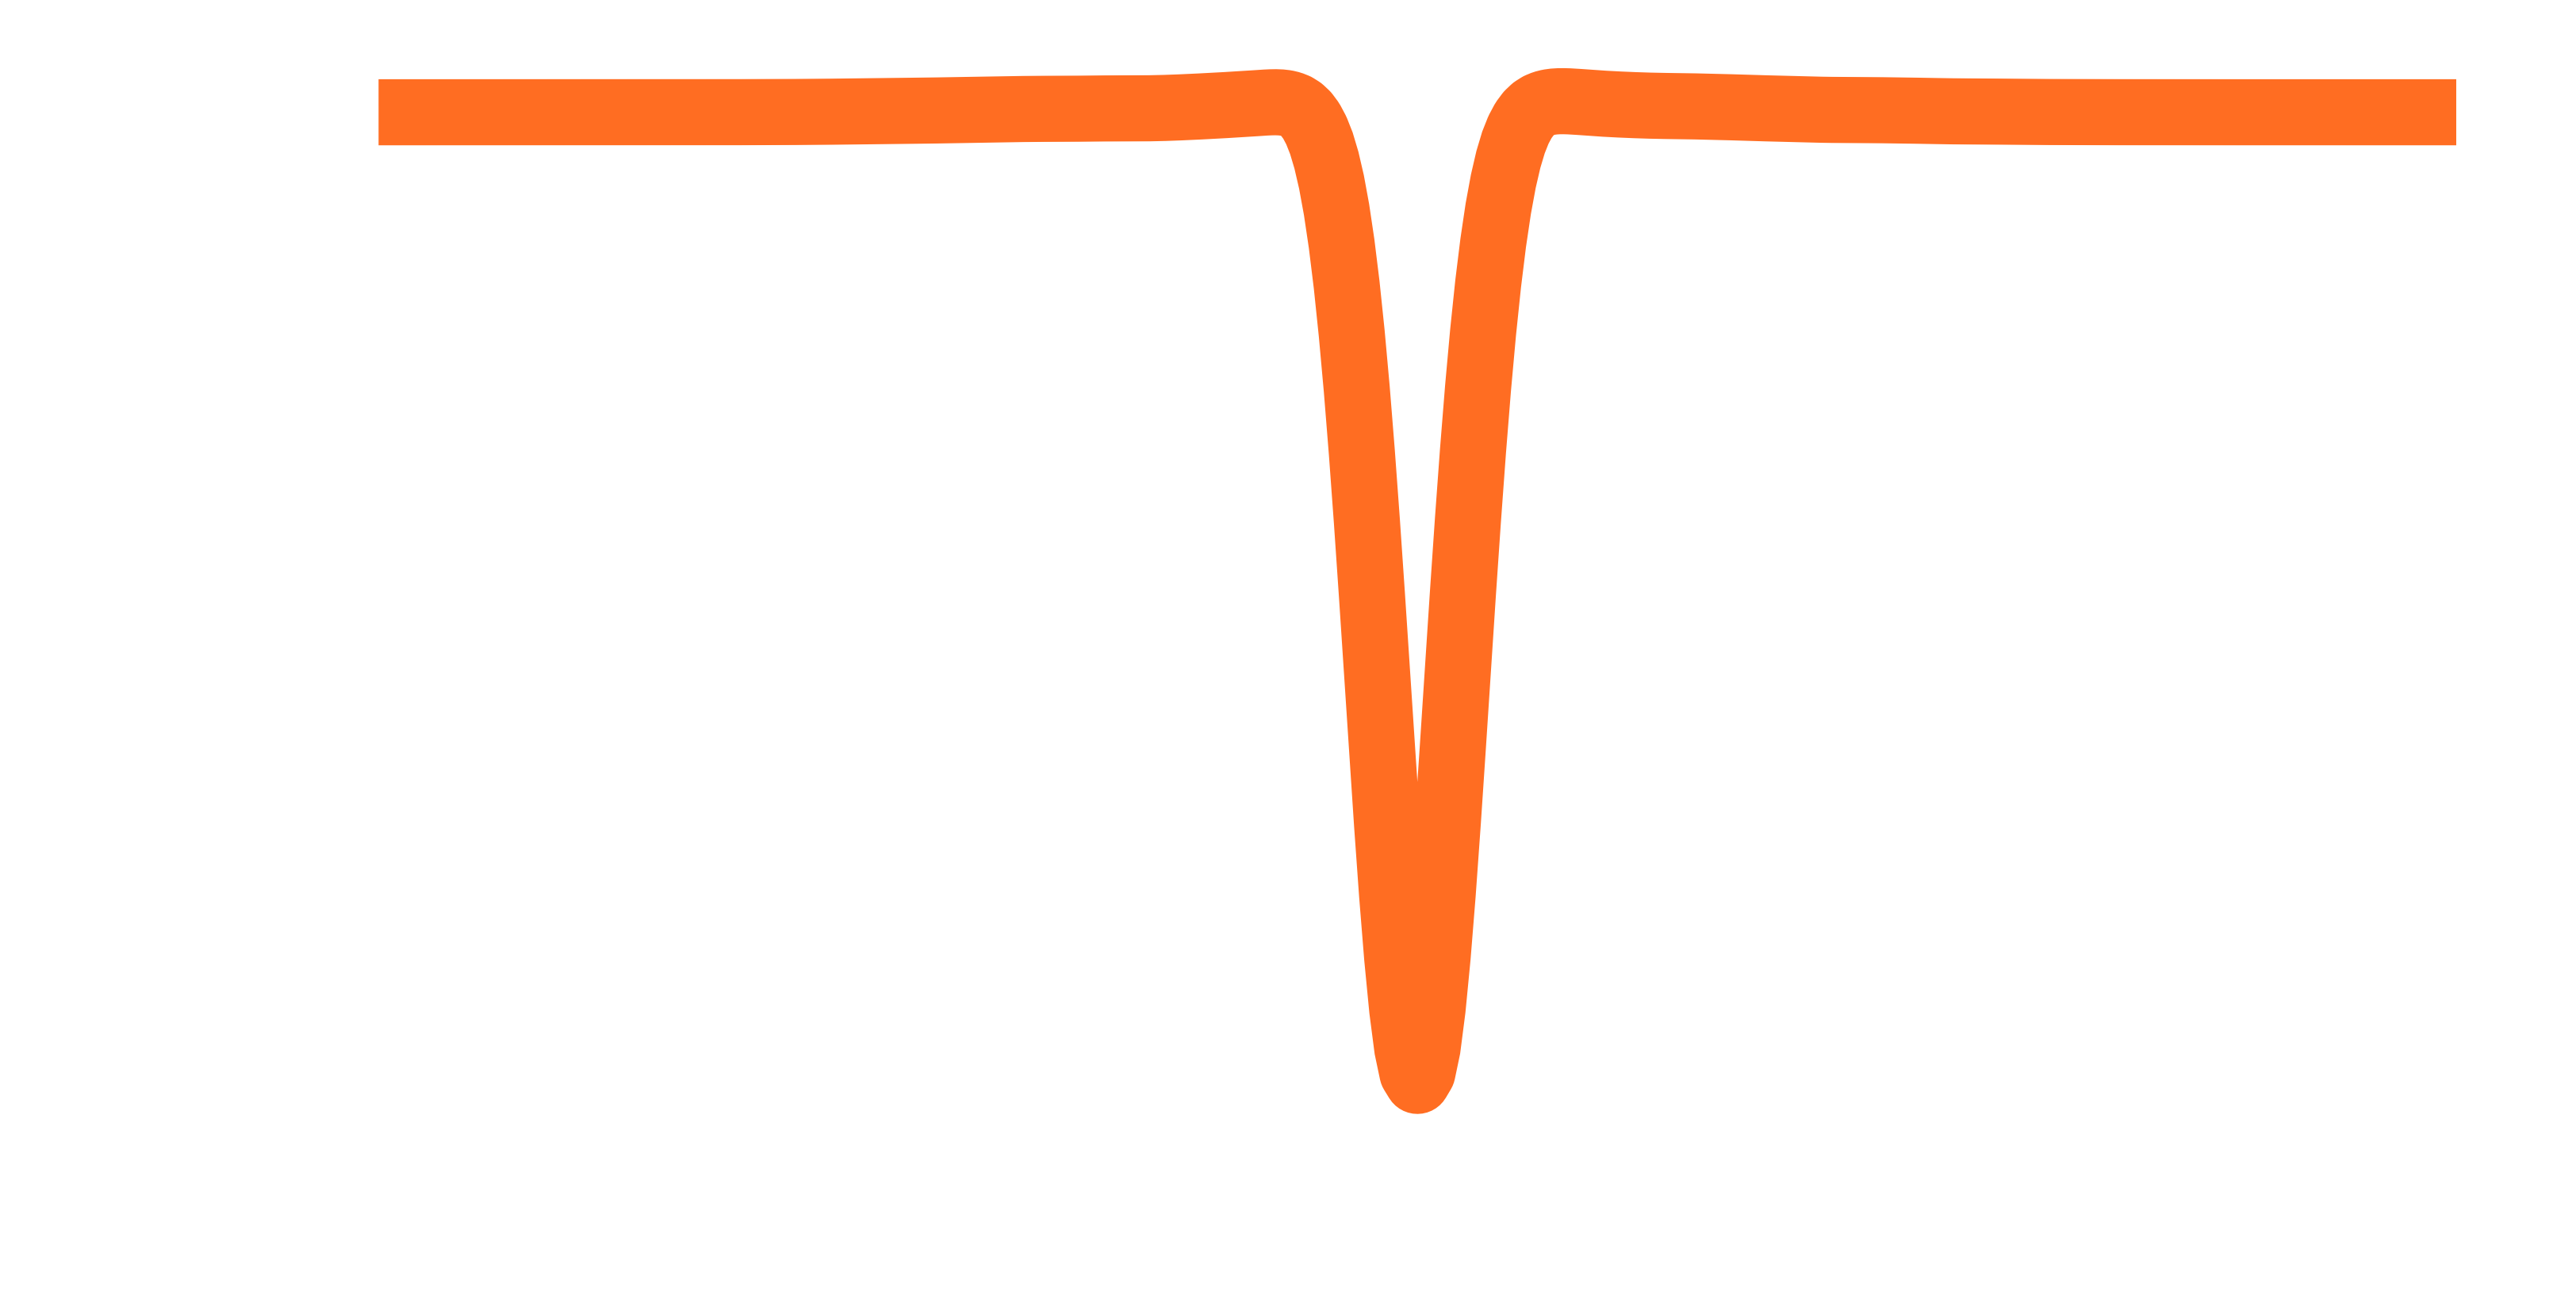

In [85]:
fig = plt.figure(figsize=(6, 3))
alpha = 0.9
plt.plot(space, alpha * center + (1 - alpha) * (0.5 * horz_pf + 0.5 * ama_pf), '#FF6D22', linewidth=10)
plt.axis('off')
plt.savefig('strong_center.png', transparent=True)

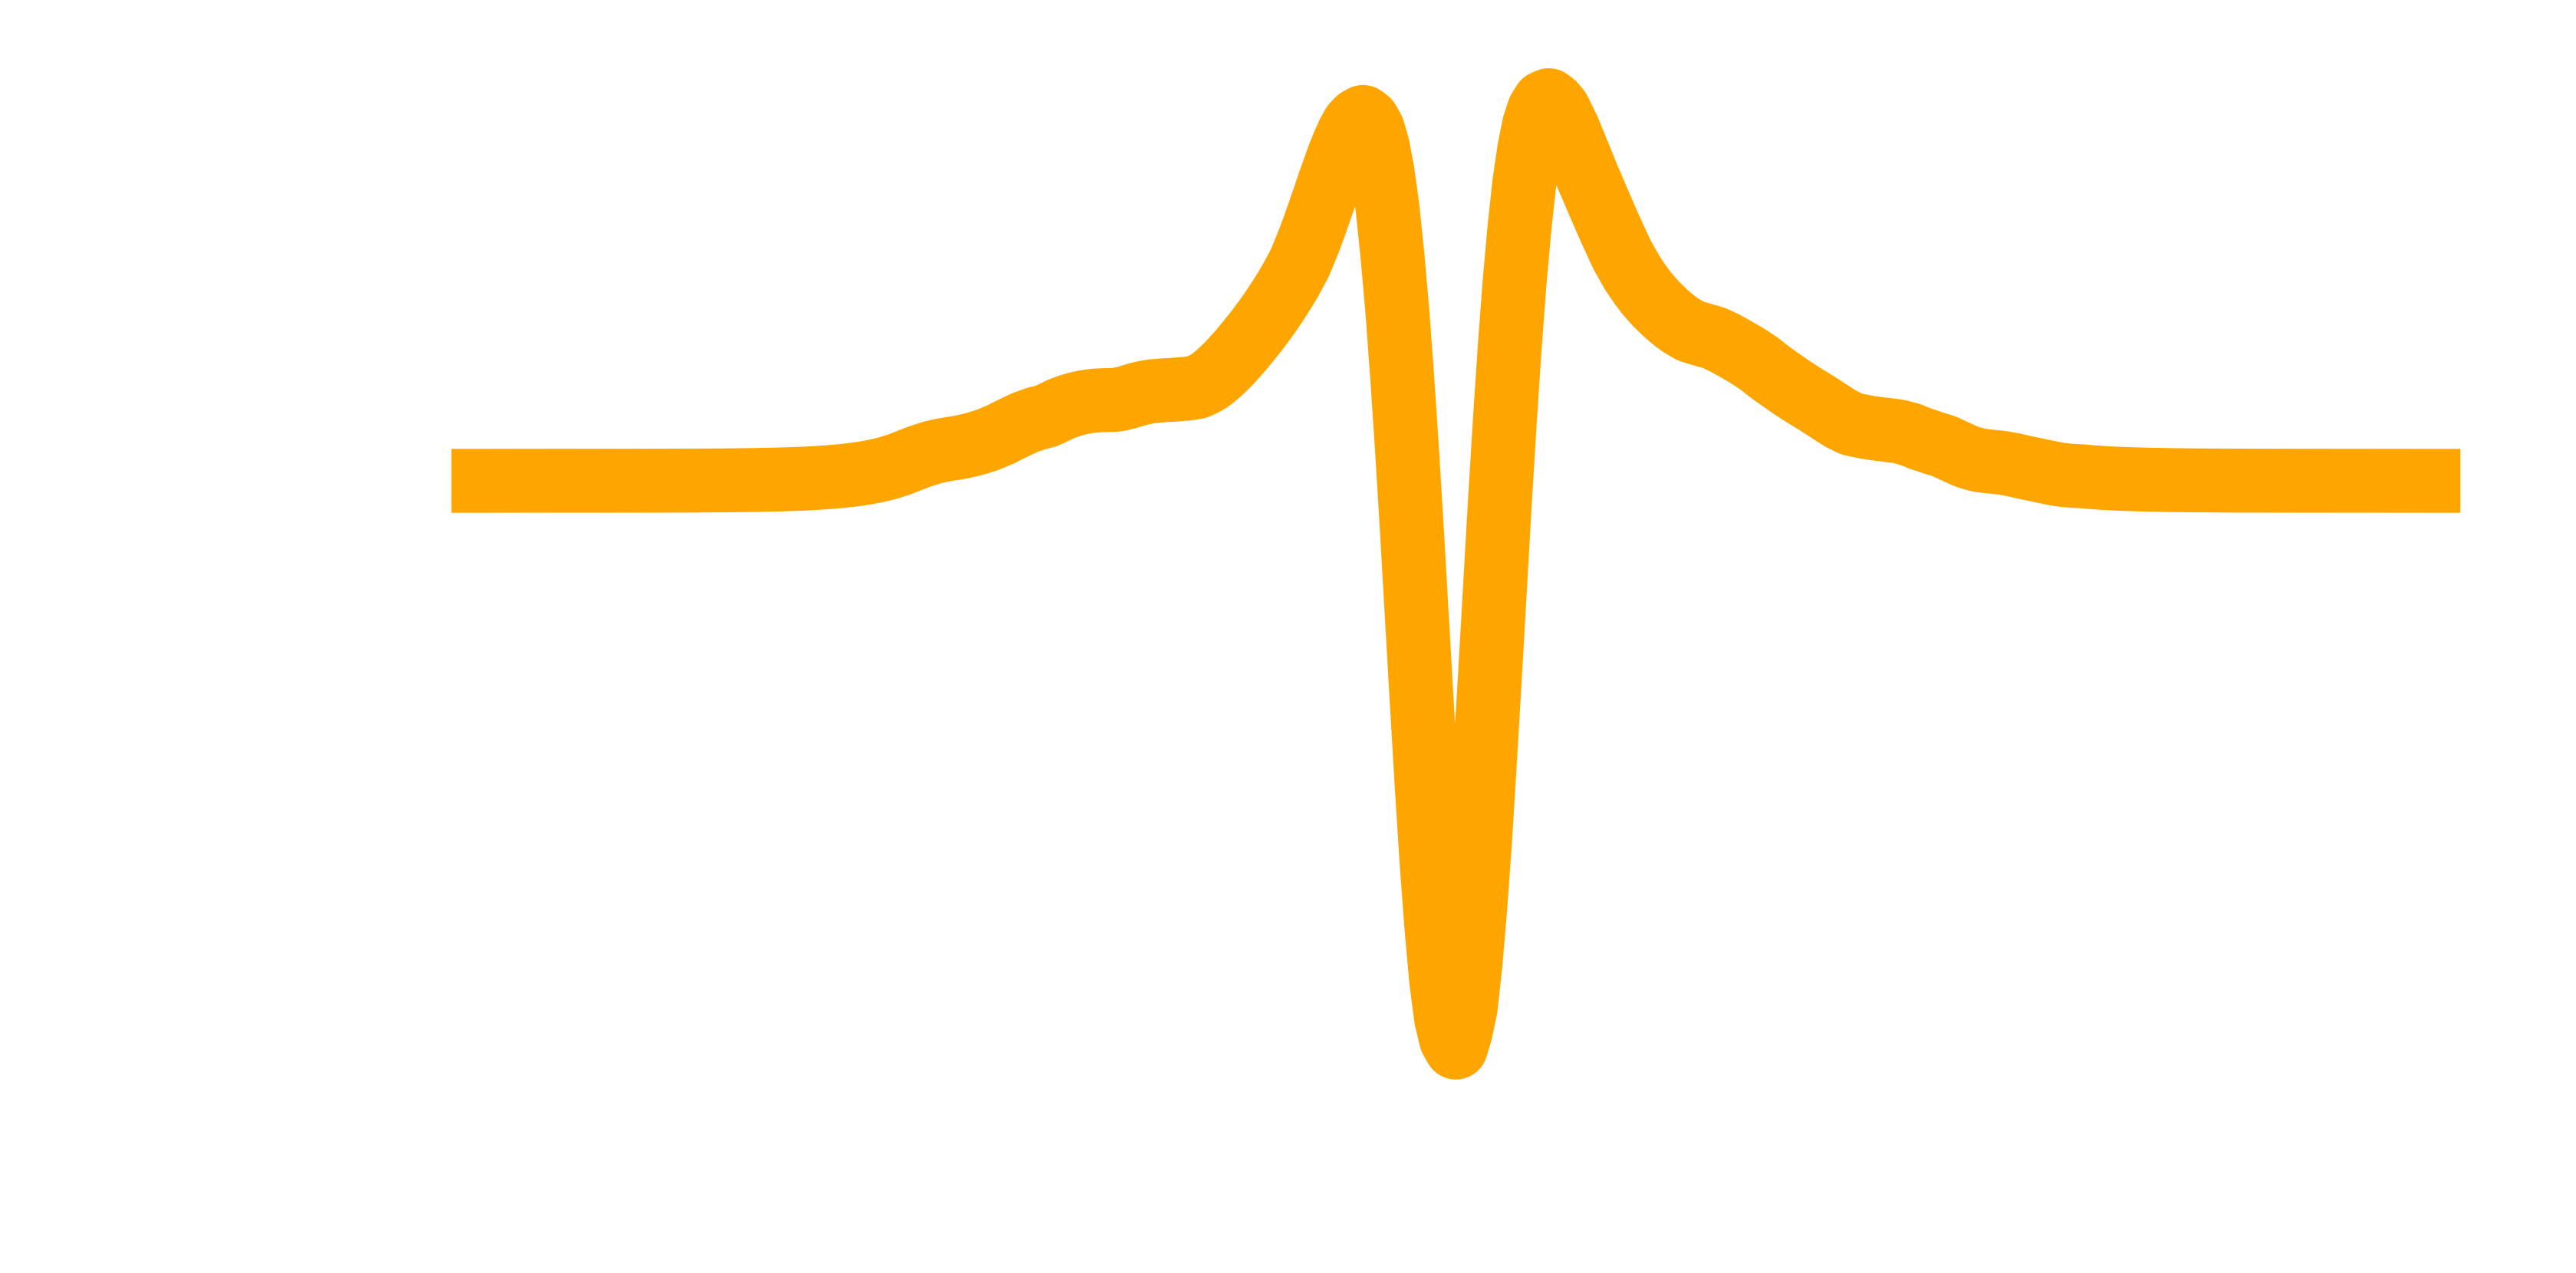

In [86]:
fig = plt.figure(figsize=(6, 3))
alpha = 0.37
plt.plot(space, alpha * center + (1 - alpha) * (0.5 * horz_pf + 0.5 * ama_pf), 'orange', linewidth=10)
plt.axis('off')
plt.savefig('weak_center.png', transparent=True)